In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
base_path = '/Users/freezylex/Documents/course_work'
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

## Upload target

In [3]:
target_path = 'data/final_target.xlsx'
target = pd.read_excel(os.path.join(base_path, target_path), index_col = 'Date',
                       parse_dates=True)
target.drop(columns=['SU26217RMFS', 'SU26218RMFS'], inplace=True)
target.head(2)

SU26214RMFS  SU26215RMFS  SU26216RMFS  SU26203RMFS  SU26204RMFS  \
Date                                                                          
2015-03-02   -71.009402   -16.198293   -51.672678   213.214039     8.877833   
2015-03-03     7.255880    45.041981    17.967756   263.188637    62.406383   

            SU26205RMFS  SU26206RMFS  SU26207RMFS  SU26208RMFS  SU26209RMFS  \
Date                                                                          
2015-03-02   -69.514138    81.363229    81.611366   -44.294101   -46.555882   
2015-03-03    10.363783   125.481830   112.795674    22.874165    26.012453   

            SU26210RMFS  SU26211RMFS  SU26212RMFS  
Date                                               
2015-03-02   -65.581271   -32.632524   103.025743  
2015-03-03     9.625523    34.752162   129.932953

## Upload metrics

In [4]:
metric_path = os.path.join(base_path, 'data/metrics_final')

rvi = pd.read_csv(os.path.join(metric_path, 'rvi.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
cds = pd.read_csv(os.path.join(metric_path, 'cds.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
usdrub = pd.read_csv(os.path.join(metric_path, 'usdrub.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
BA = pd.read_csv(os.path.join(metric_path, 'BA.csv'), index_col = 'Date', parse_dates = True)
TC = pd.read_csv(os.path.join(metric_path, 'TC.csv'), index_col = 'Date', parse_dates = True)
PD = pd.read_csv(os.path.join(metric_path, 'PD.csv'), index_col = 'Date', parse_dates = True)
TR = pd.read_excel(os.path.join(metric_path, 'till_redemption.xlsx'), index_col = 'Date', parse_dates = True)


## Join 

In [5]:
available_indexes = list((set(rvi.index) & set(cds.index) & \
                          set(usdrub.index) & set(BA.index) & set(target.index)))
available_indexes = np.sort(np.array(available_indexes))

In [6]:
target = target.loc[available_indexes]

rvi = rvi.loc[available_indexes]
cds = cds.loc[available_indexes]
usdrub = usdrub.loc[available_indexes]
BA = BA.loc[available_indexes]
TC = TC.loc[available_indexes]
PD = PD.loc[available_indexes]
TR = TR.loc[available_indexes]

## Create dataset

In [7]:
id_ = np.arange(1, len(target.columns) + 1)
id_ = np.tile(id_, cds.shape[0])

complete_data = pd.DataFrame(columns = ['id', 'time', 'bond', 'log_PD', 
                                        'log_BA', 'log_TC', 'TR', 'RVI', 'CDS','USDRUB','target'])
complete_data['id'] = id_
complete_data['time'] = np.repeat(BA.index, repeats=13) #number of bonds
complete_data

id       time bond log_PD log_BA log_TC   TR  RVI  CDS USDRUB target
0      1 2015-06-02  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
1      2 2015-06-02  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
2      3 2015-06-02  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
3      4 2015-06-02  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
4      5 2015-06-02  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
...   ..        ...  ...    ...    ...    ...  ...  ...  ...    ...    ...
1815   9 2016-02-19  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
1816  10 2016-02-19  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
1817  11 2016-02-19  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
1818  12 2016-02-19  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN
1819  13 2016-02-19  NaN    NaN    NaN    NaN  NaN  NaN  NaN    NaN    NaN

[1820 rows x 11 columns]

In [8]:
transfer = {'SU26214RMFS':1, 
            'SU26215RMFS':2, 
            'SU26216RMFS':3, 
            'SU26203RMFS':4,
            'SU26204RMFS':5, 
            'SU26205RMFS':6, 
            'SU26206RMFS':7, 
            'SU26207RMFS':8,
            'SU26208RMFS':9, 
            'SU26209RMFS':10, 
            'SU26210RMFS':11, 
            'SU26211RMFS':12,
            'SU26212RMFS':13}

def make_feature(df, feature_name):
    global complete_data
    for column in df.columns:
        bond_data = df[column]
        try: #Костыль, так как в текущем датасете нет одного бонда
            number = transfer[column]
            for date in bond_data.index:
                complete_data.loc[(complete_data['id'] ==number)&(complete_data['time'] == date), feature_name] = bond_data.loc[date]
        except:
            pass
            
list_with_dfs = [('log_PD', PD), 
                 ('log_TC', TC), 
                 ('log_BA', BA),
                 ('TR', TR),
                 ('target', target)]

for feature, dataframe in tqdm(list_with_dfs):
    make_feature(dataframe, feature)

100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


In [9]:
complete_data['bond'] = np.tile(target.columns.values, reps=BA.shape[0])

complete_data['RVI'] = np.repeat(rvi['RVI'].values, repeats=len(target.columns))
complete_data['RVI_struct_coef'] = np.repeat(rvi['struct_coef'].values, repeats=len(target.columns))
complete_data['struct_change_Jan'] = np.repeat(rvi['dummy_struct_change'].values, repeats=len(target.columns))

complete_data['CDS_dummy'] = np.repeat(cds['CDS_dummy_struct'].values, repeats=len(target.columns))
complete_data['CDS'] = np.repeat(cds['CDS1Y'].values, repeats=len(target.columns))
complete_data['CDS_new_slope'] = np.repeat(cds['CDS_struct_coef'].values, repeats=len(target.columns))

complete_data['USDRUB'] = np.repeat(usdrub['USDRUB_CBR'].values, repeats=len(target.columns))
complete_data['oil_shock_1st_USDRUB_dummy'] = np.repeat(usdrub['dummy_1_oil_shock'].values, repeats=len(target.columns))
complete_data['oil_shock_1st_USDRUB_coef'] = np.repeat(usdrub['USDcoef_oil_shock_1'].values, repeats=len(target.columns))


In [10]:
short_term_indicator = [0,0,0,1,0,0,1,0,0,0,0,0,0]
short_term_indicator = np.tile(short_term_indicator, reps=target.shape[0])
complete_data['short_term_bond'] = short_term_indicator

In [11]:
complete_data.head(2)

id       time         bond    log_PD    log_BA    log_TC        TR    RVI  \
0   1 2015-06-02  SU26214RMFS -0.793177  4.007151   2.70805  4.989041  38.34   
1   2 2015-06-02  SU26215RMFS -0.522765  5.010502  2.079442  8.210959  38.34   

      CDS   USDRUB     target  RVI_struct_coef  struct_change_Jan  CDS_dummy  \
0  227.12  52.8213  79.195092              0.0                  0          0   
1  227.12  52.8213  75.613379              0.0                  0          0   

   CDS_new_slope  oil_shock_1st_USDRUB_dummy  oil_shock_1st_USDRUB_coef  \
0            0.0                           1                    52.8213   
1            0.0                           1                    52.8213   

   short_term_bond  
0                0  
1                0

In [12]:
complete_data['LT_BA'] = BA[BA.columns[13:]].values.ravel(order='C')
complete_data['LT_PD'] = PD[PD.columns[13:]].values.ravel(order='C')
complete_data['LT_TC'] = TC[TC.columns[13:]].values.ravel(order='C')

In [13]:
train_sample = complete_data[complete_data['time'] <= '2016-02-01']
test_sample = complete_data[complete_data['time'] >= '2016-02-01']

In [14]:
train_sample.to_excel(os.path.join(base_path, 'data/Macro_LM_train.xlsx'))
test_sample.to_excel(os.path.join(base_path, 'data/Macro_LM_test.xlsx'))

# Build up the model

- Create RE and FE models
- Get info
- Plot graphs

### Important source:

https://bashtage.github.io/linearmodels/panel/examples/examples.html

In [15]:
from linearmodels.panel import RandomEffects, PanelOLS, BetweenOLS
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
from linearmodels.panel import compare

In [16]:
exog_vars = ['CDS', 'CDS_new_slope', 'CDS_dummy', 'RVI', 'RVI_struct_coef', 'struct_change_Jan',
             'USDRUB', 'short_term_bond', 'log_TC', 'LT_TC'] #TR
inverse_transfer = {}
for key, val in transfer.items():
    inverse_transfer[val] = key

In [17]:
def create_info_table(true_vals, predicted_vals, transformer_dict):
    info_table = true_vals.reset_index().merge(predicted_vals.reset_index(), on=['id', 'time'])
    info_table = info_table[['id', 'time', 'target', 'predictions']]
    info_table['target'] = info_table['target'].astype('float')
    info_table['predictions'] = info_table['predictions'].astype('float') #DataFrame with id, time, target and pred 
    #for the whole time-span of the train or test sample
    
    info_table['error'] = np.abs(info_table['target'] - info_table['predictions'])
    info_table['error_2'] = info_table['error'] ** 2
    summary_table = pd.concat([info_table.groupby('id').mean()[['error']], np.sqrt(info_table.groupby('id').mean()[['error_2']])], axis=1)
    summary_table.columns = ['MAE', 'RMSE']
    summary_table.index = list(transformer_dict.values())
    return info_table, summary_table


In [18]:
def build_model(train, test, model_class, 
                short_list, cov_type=None):
    '''
    Assumes that both train and test dataframes have 'target' column.
    '''
    ### TRAIN THE MODEL
    train = train.set_index(['id', 'time'])
    exog_vars_train = sm.add_constant(train[short_list])
    train['target'] = train['target'].astype('float')
    exog_vars_train = exog_vars_train.astype('float')
    model_init = model_class(train.target, 
                             exog_vars_train)
    if cov_type:
        model = model_init.fit(cov_type=cov_type)
    else:
        model = model_init.fit()
    predictions_train = pd.DataFrame(model.fitted_values)
    predictions_train.rename(columns={'fitted_values':'predictions'}, inplace=True)
    
    ### TEST THE MODEL
    test = test.set_index(['id', 'time'])
    test['const'] = 1
    test_= test[['const'] + short_list]
    predictions_test = model.predict(test_)
    
    info_train, summary_train = create_info_table(train, predictions_train, inverse_transfer)
    info_test, summary_test = create_info_table(test, predictions_test, inverse_transfer)
    return model, info_train, summary_train, info_test, summary_test

In [34]:
def make_plots(train, test, dir_to_save, dict_inv):
    dir_ = os.path.join(base_path, dir_to_save)
    if not os.path.exists(dir_):
        os.mkdir(dir_)
    whole_sample = pd.concat([train, test])
    for ind, obj in whole_sample.groupby('id'):
        fig, ax = plt.subplots(figsize=(15, 10))
        sns.lineplot(x = obj['time'], y = obj['target'], color='r', label='Target value', ax = ax)
        sns.lineplot(x = obj['time'], y = obj['predictions'], color='b', label='Model prediction', ax = ax)
        ax.grid()
        plt.ylabel('Spread value, b.p.')
        plt.xlabel('Date')
        ax.set_title(f'Target and prediction dynamics for bond {dict_inv[ind]}')
        ax.vlines(x=[datetime(2016, 2, 1)], ymin = min(min(obj['target']), min(obj['predictions'])),
                          ymax = max(max(obj['target']), max(obj['predictions'])))
        dir_temp = os.path.join(dir_, dict_inv[ind])
        plt.savefig(dir_temp, dpi=300)

### RE model

In [35]:
re_model, train_data, train_summary, \
test_data, test_summary = build_model(train_sample, test_sample, RandomEffects, exog_vars)

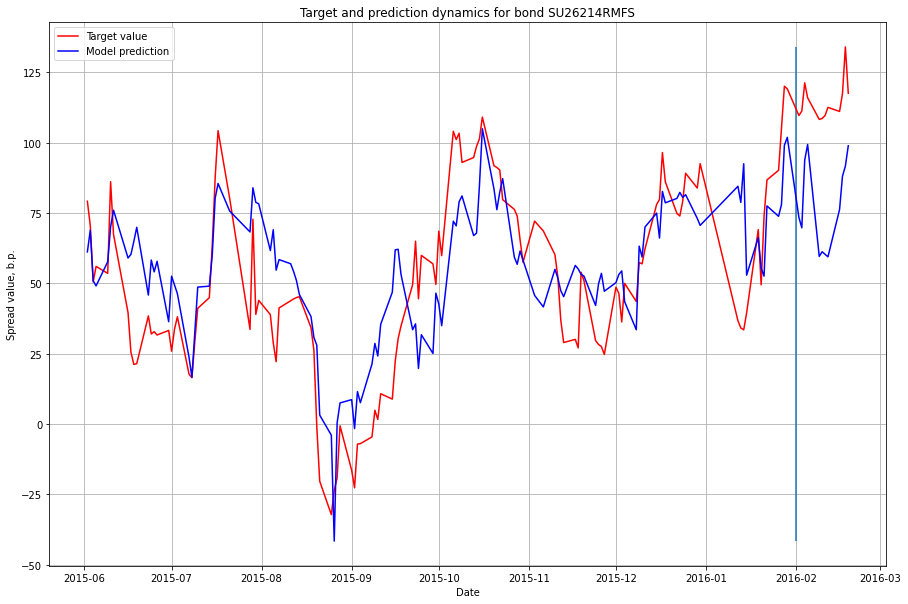

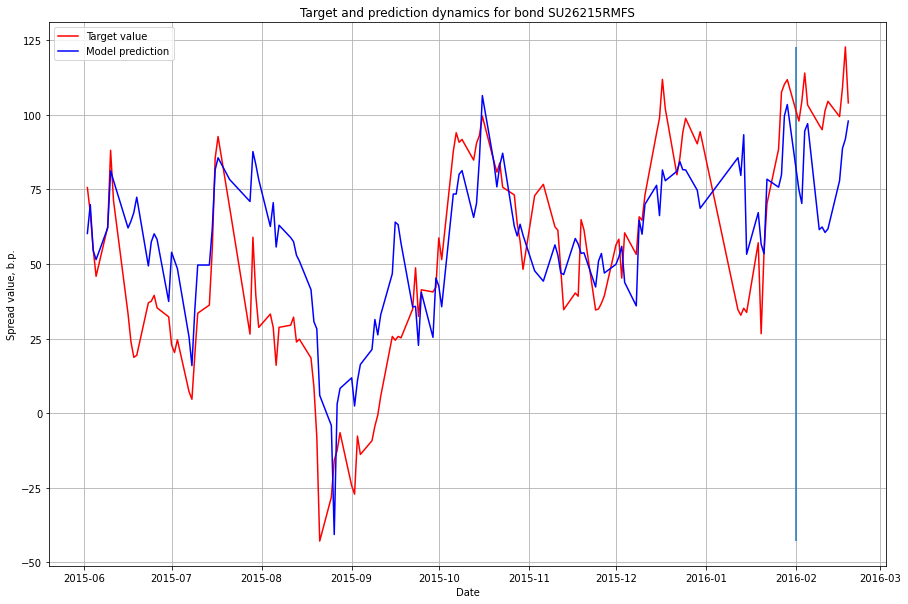

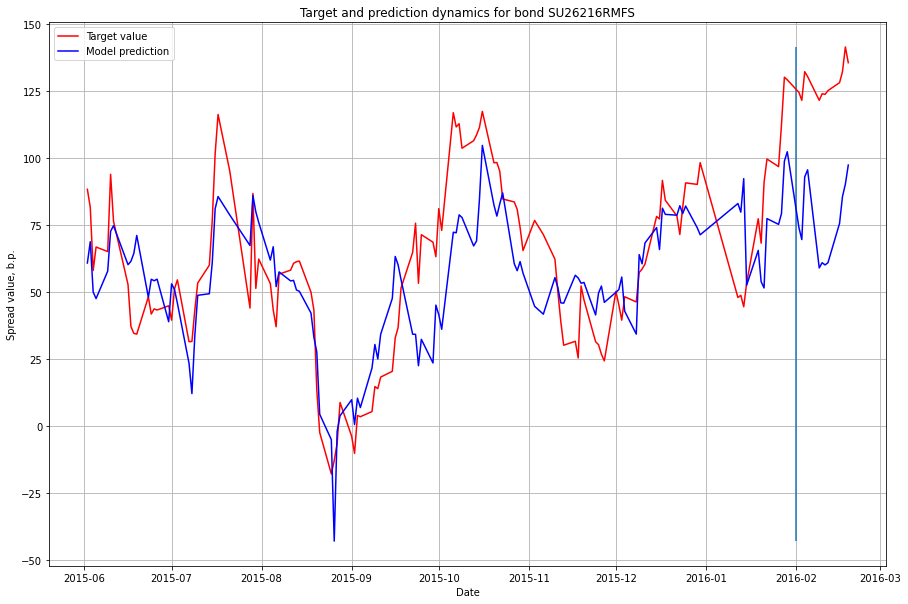

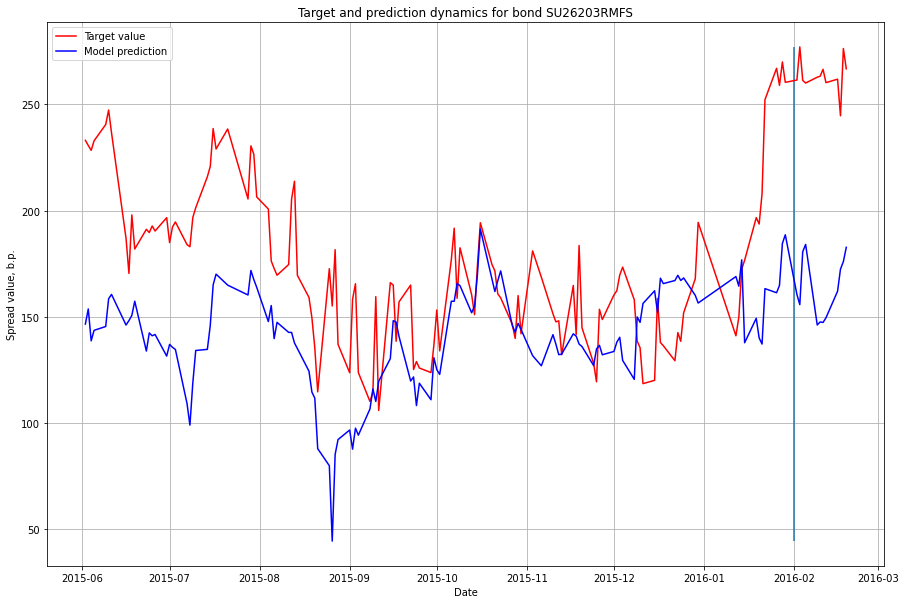

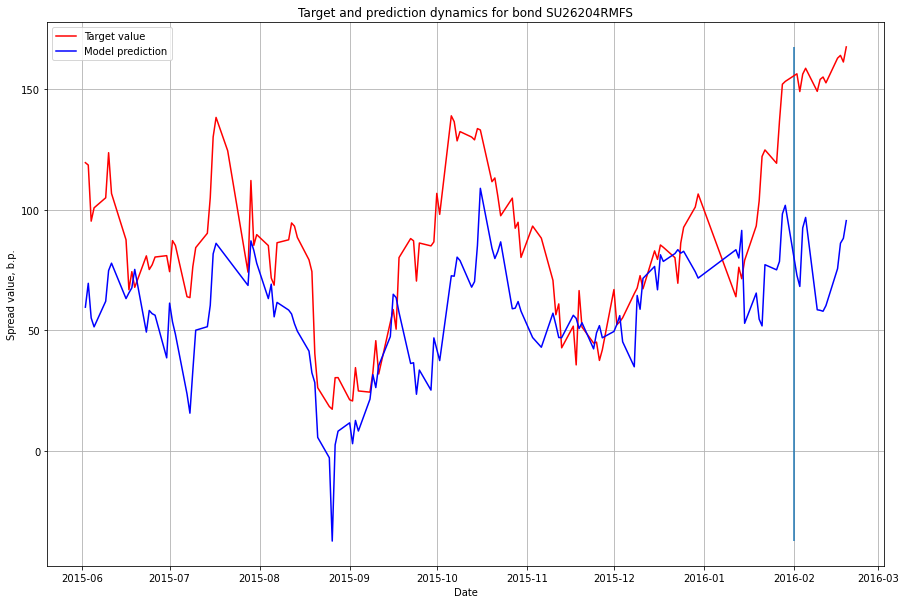

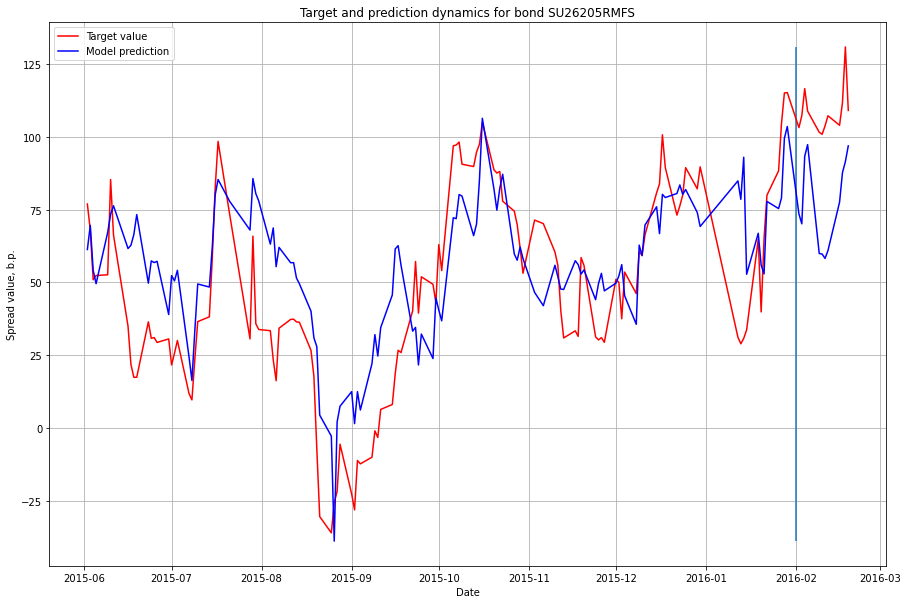

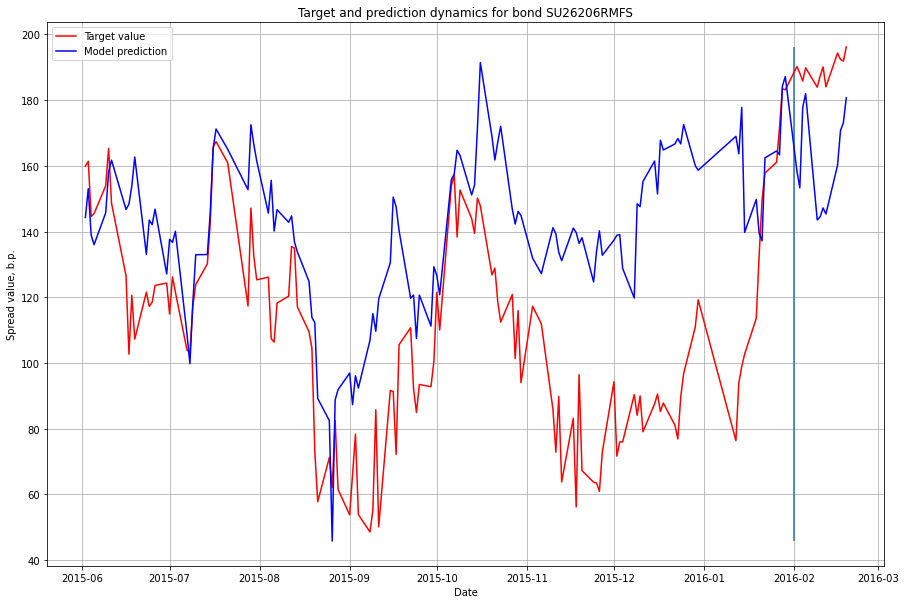

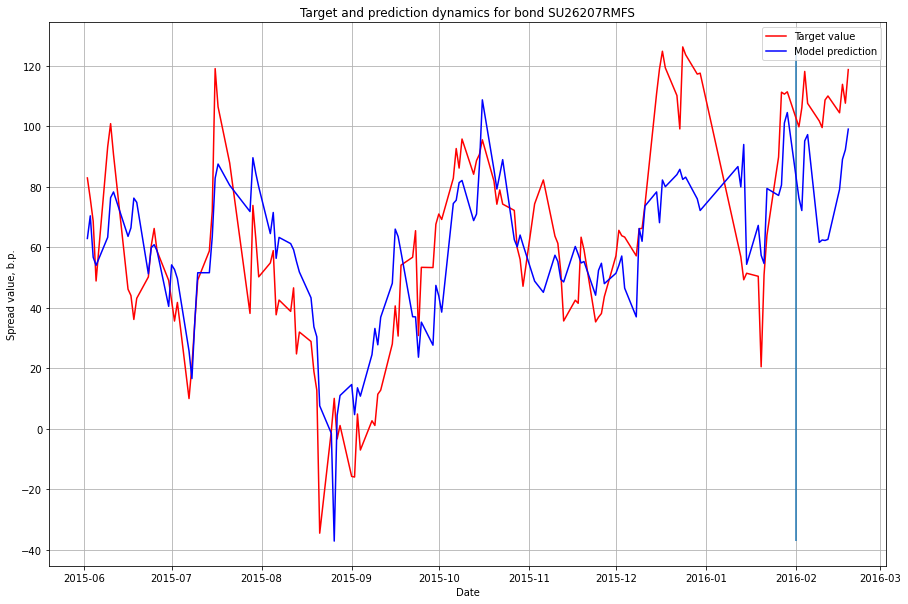

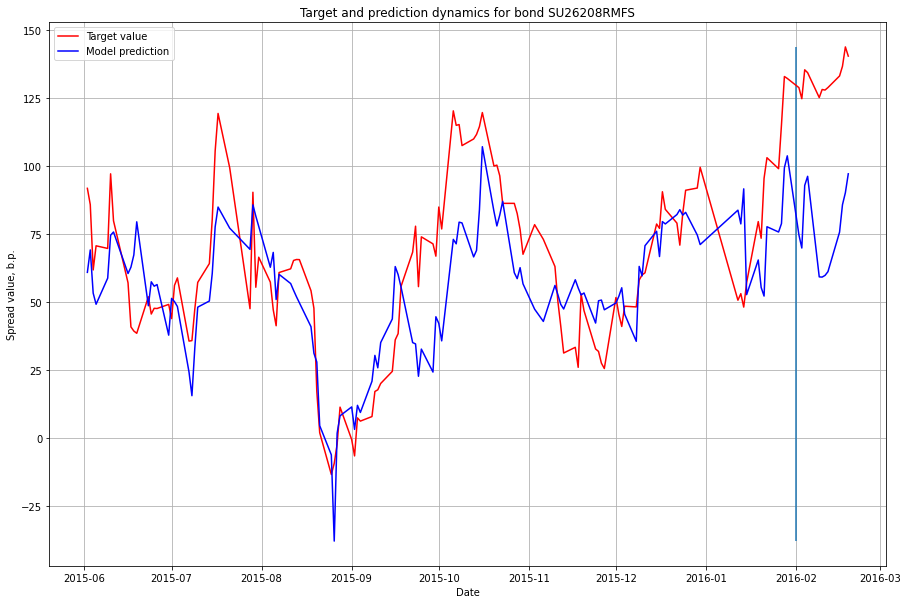

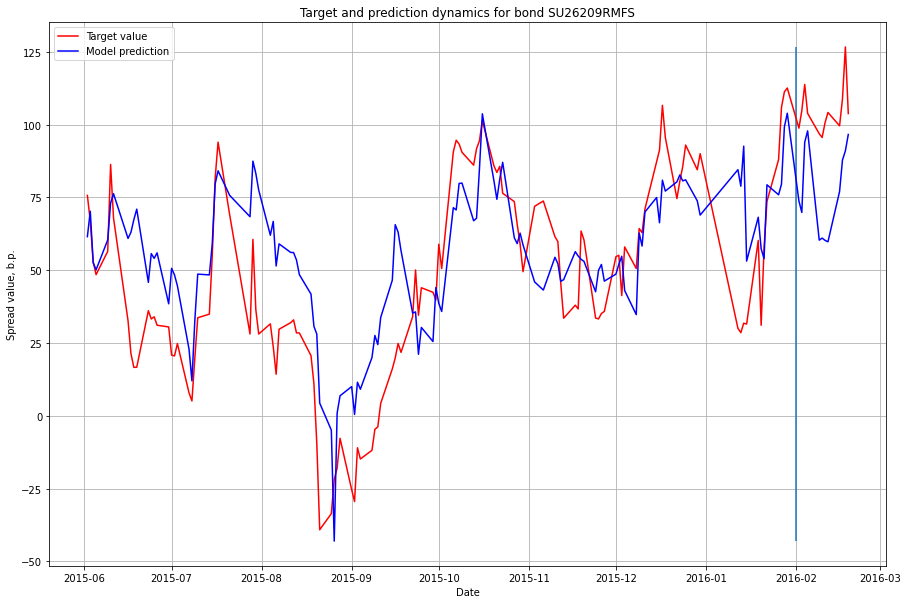

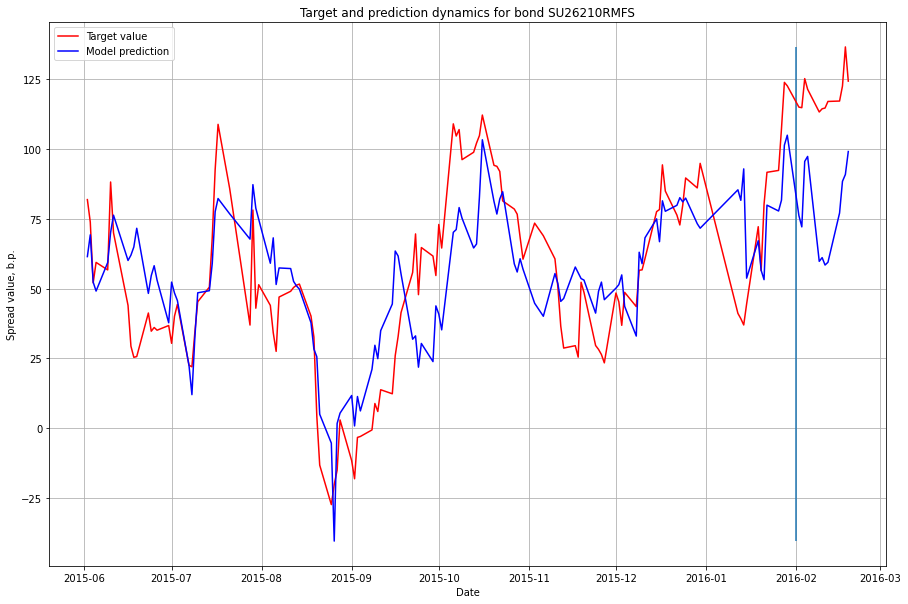

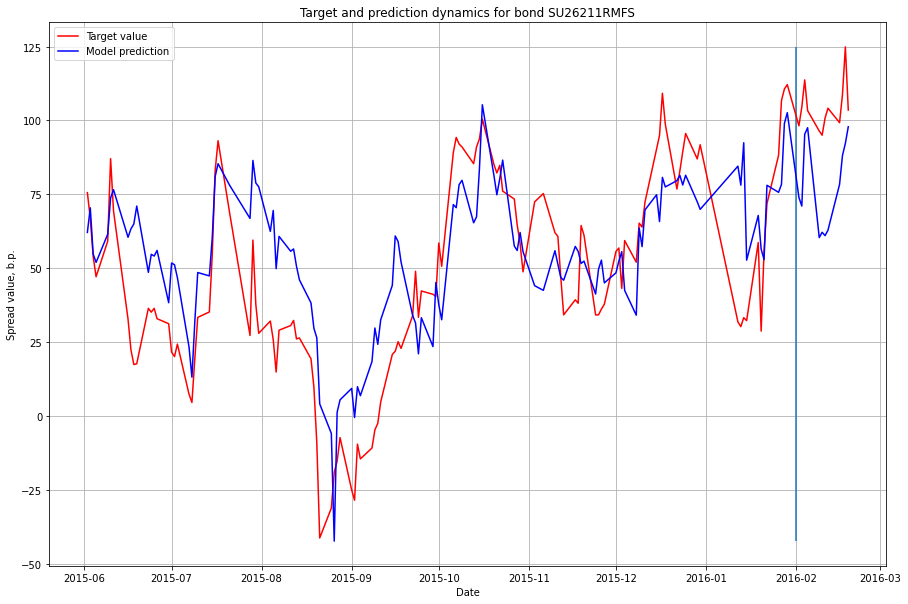

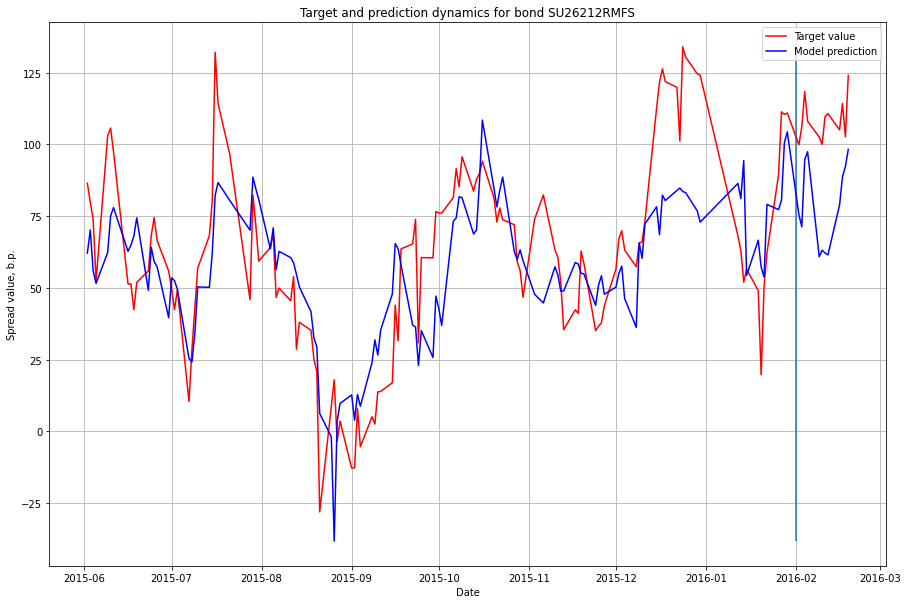

In [36]:
make_plots(train_data, test_data, 'graphs/RE_model', inverse_transfer)

In [22]:
re_model.variance_decomposition

Effects                   1409.914640
Residual                   538.221119
Percent due to Effects       0.723725
Name: Variance Decomposition, dtype: float64

In [23]:
re_model.theta

theta
id         
1   0.94547
2   0.94547
3   0.94547
4   0.94547
5   0.94547
6   0.94547
7   0.94547
8   0.94547
9   0.94547
10  0.94547
11  0.94547
12  0.94547
13  0.94547

### BE model

In [24]:
be_model, train_data, train_summary, \
test_data, test_summary = build_model(train_sample, test_sample, BetweenOLS, exog_vars)

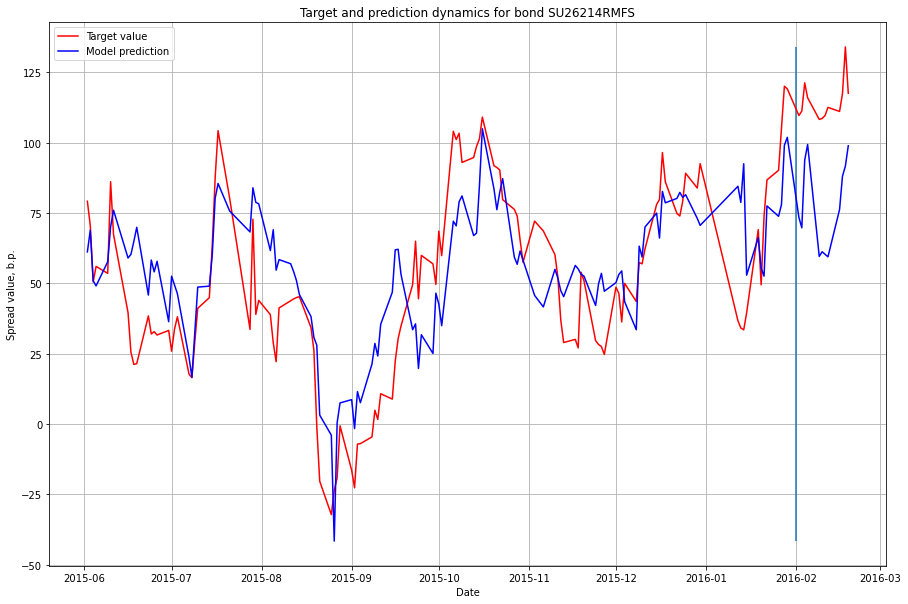

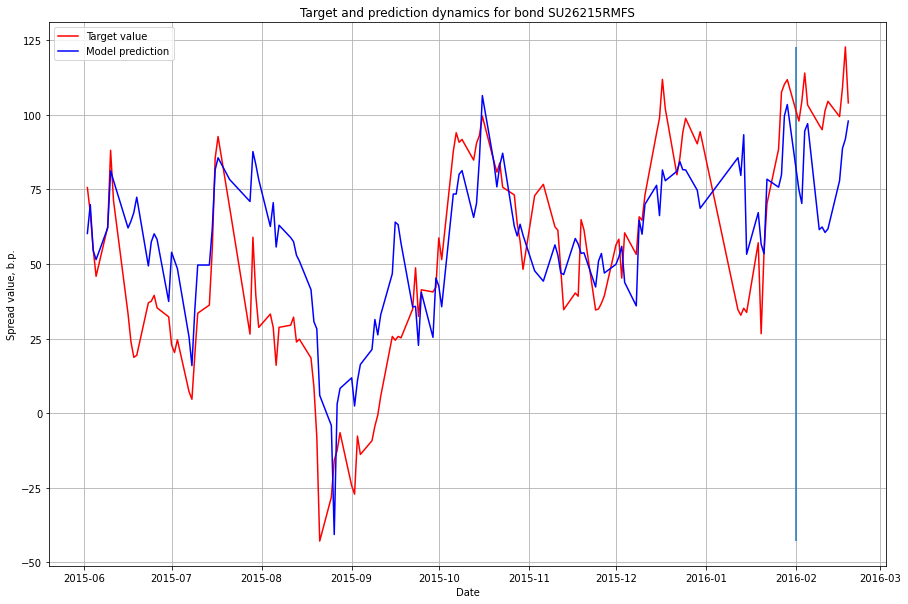

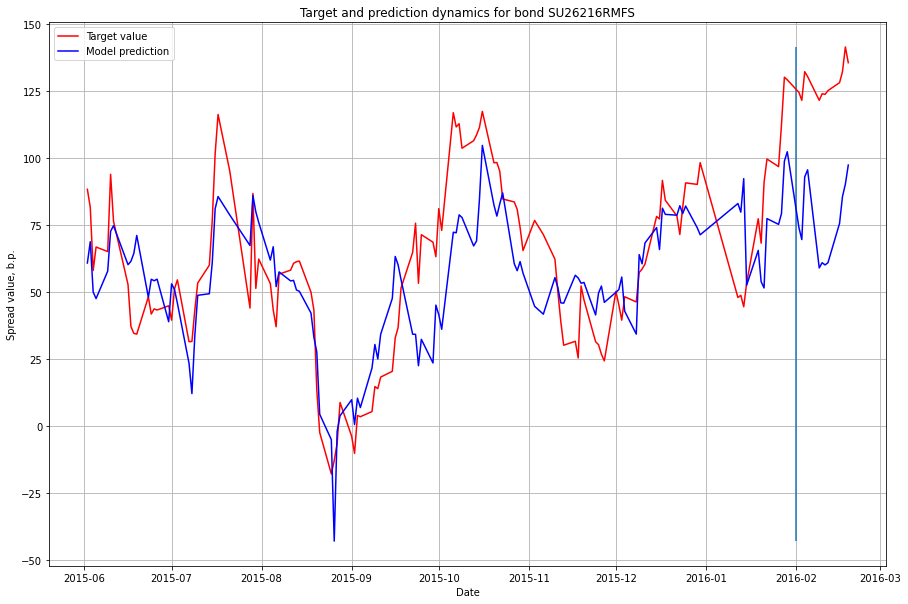

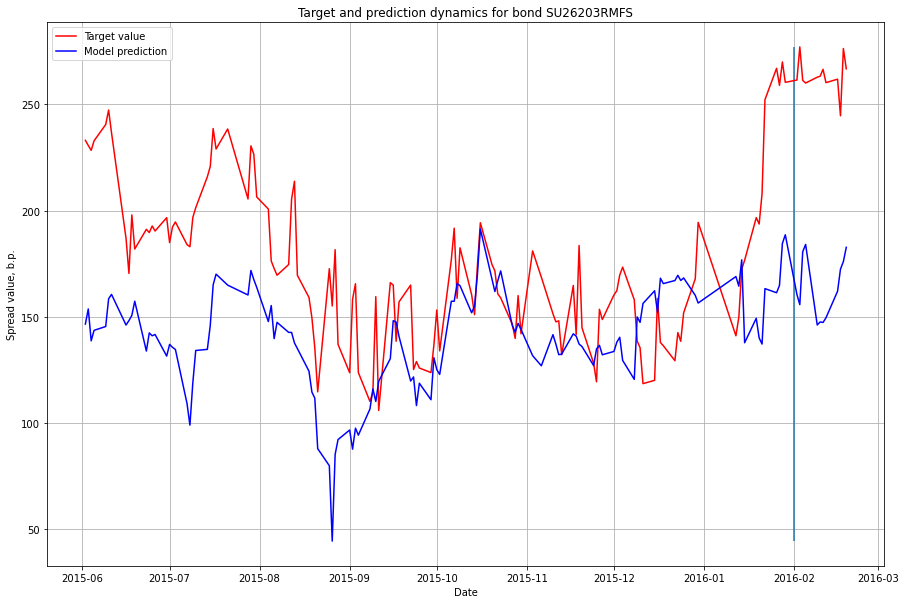

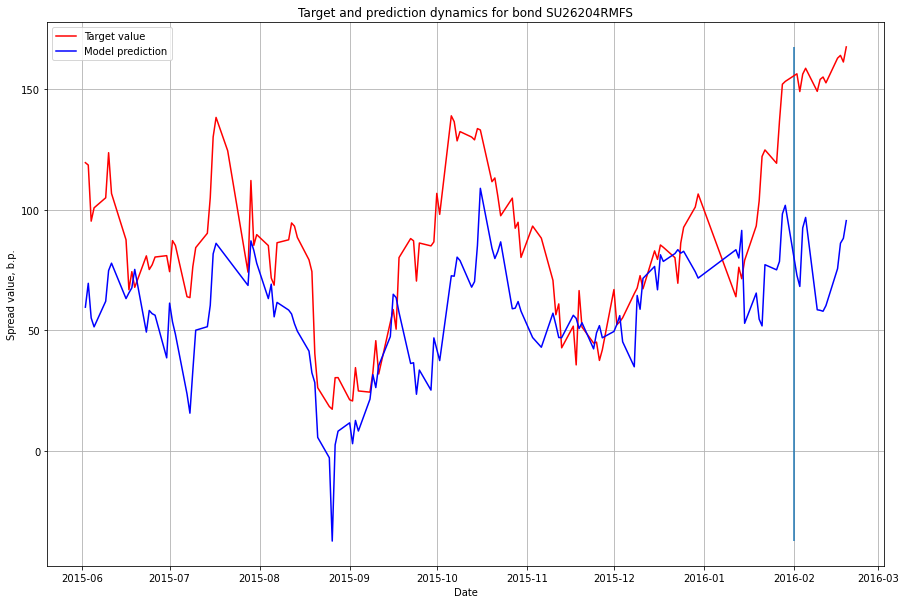

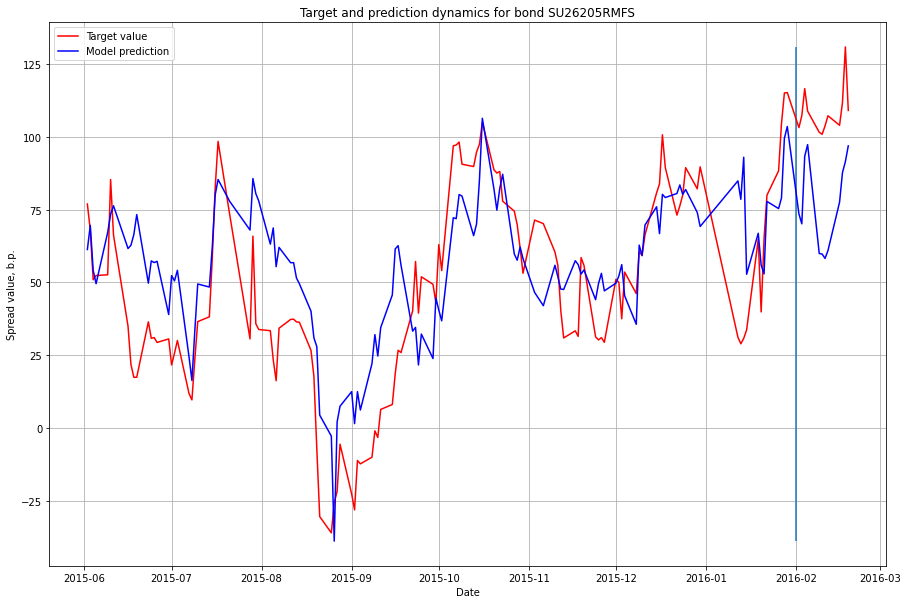

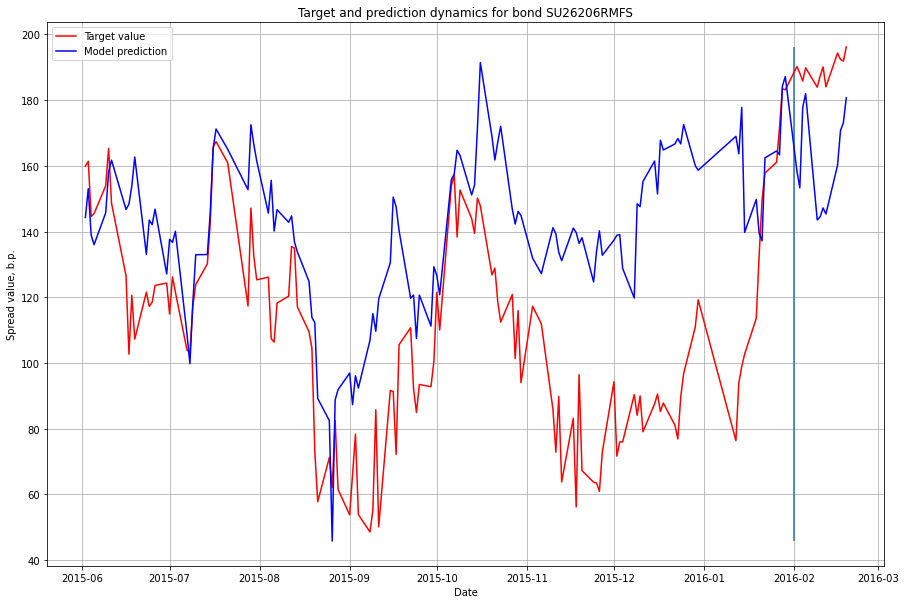

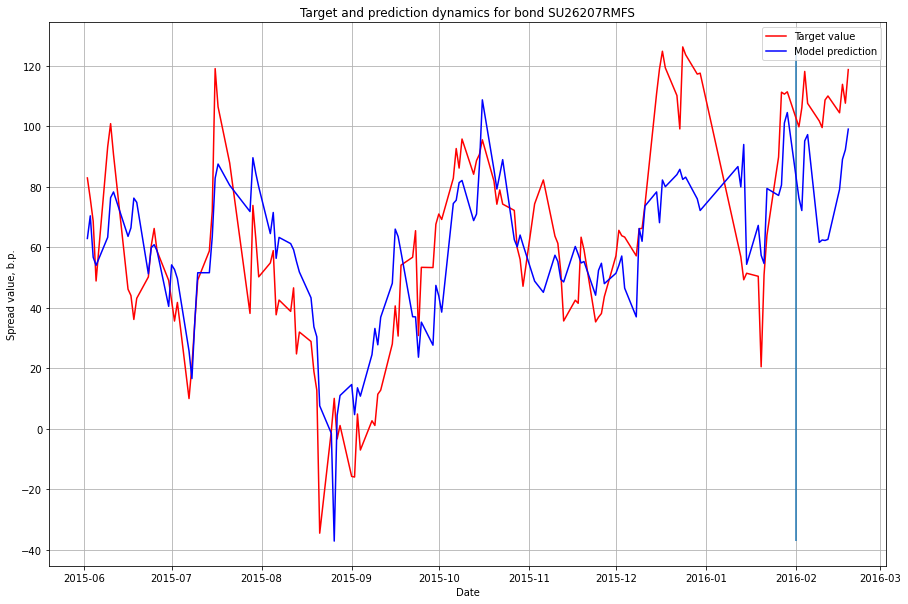

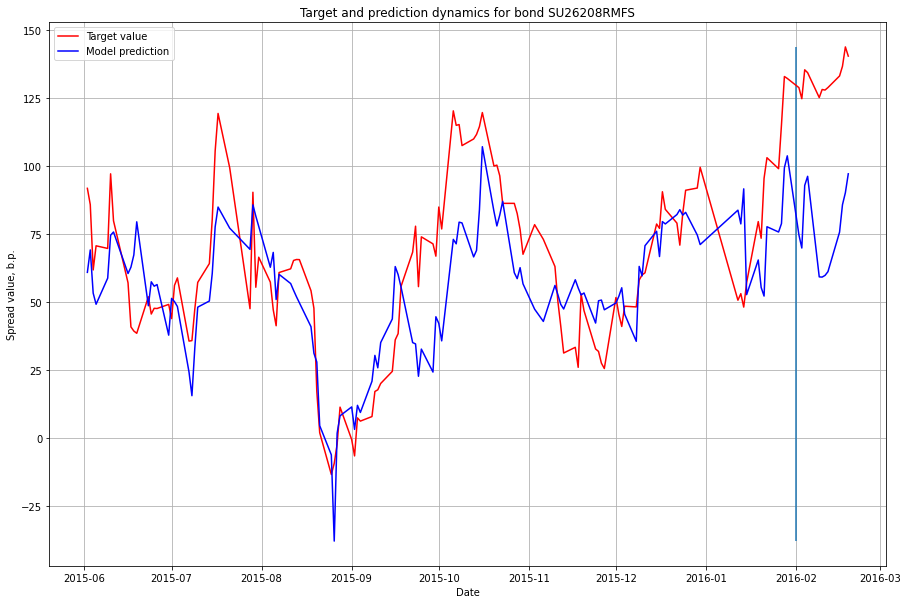

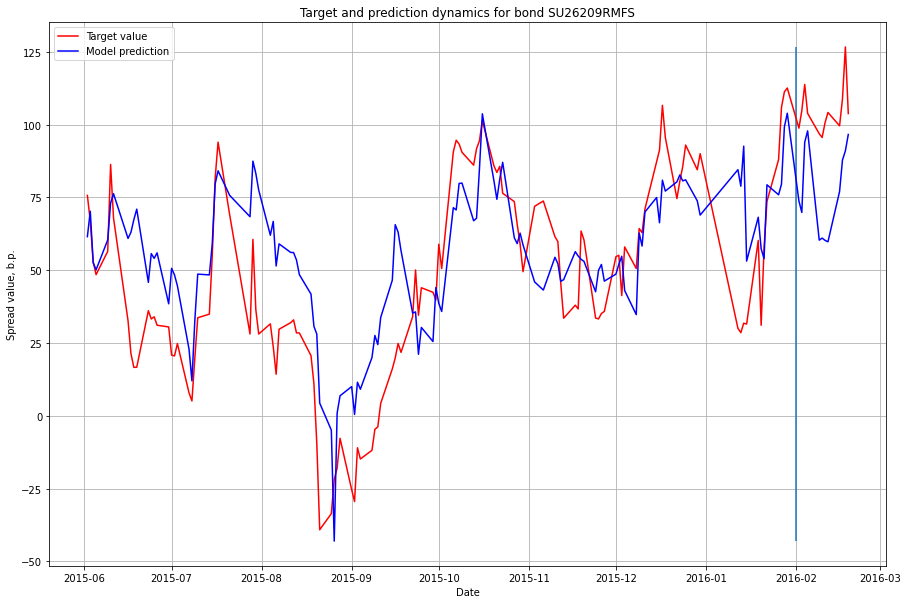

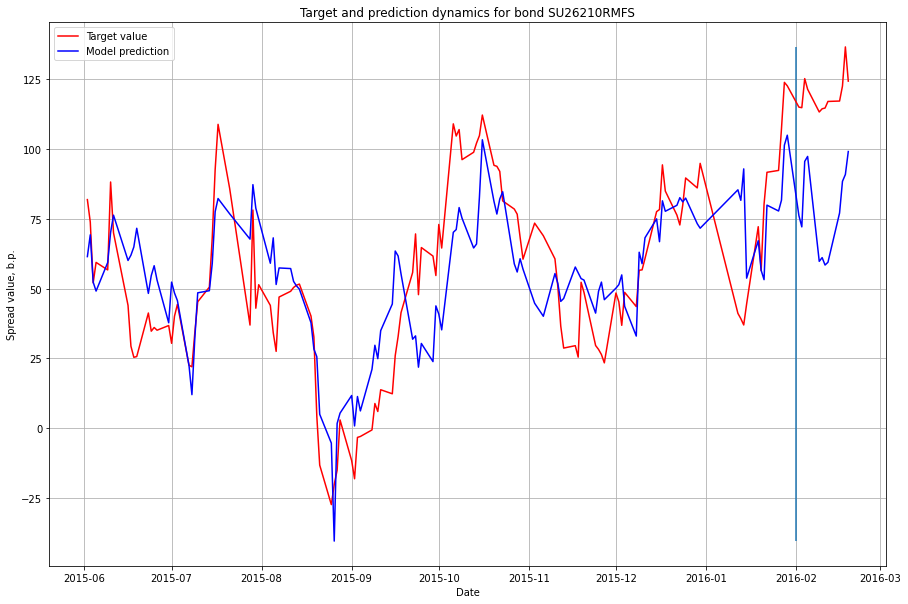

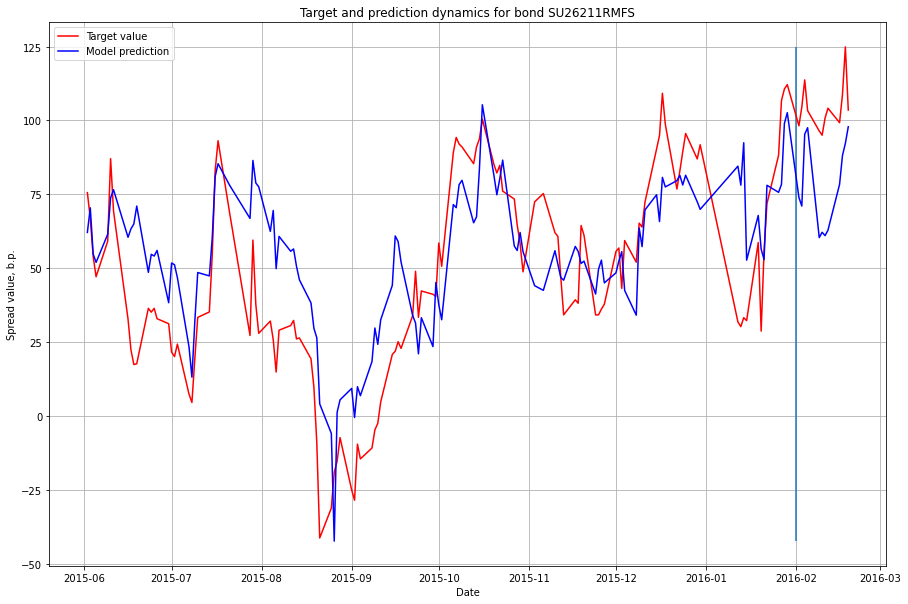

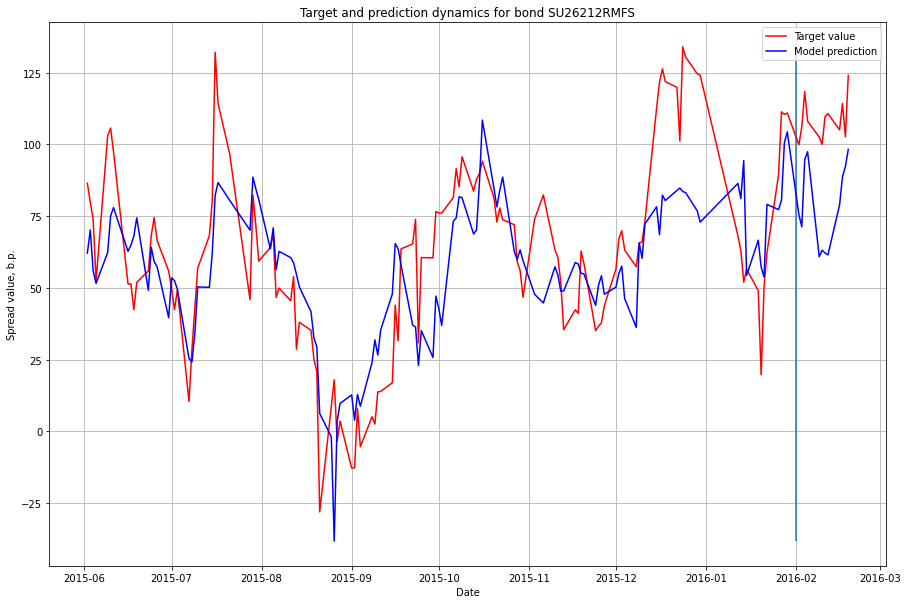

In [37]:
make_plots(train_data, test_data, 'graphs/BE_model', inverse_transfer)

### FE model

In [38]:
fe_model, train_data, train_summary, \
test_data, test_summary = build_model(train_sample, test_sample, PanelOLS, exog_vars)

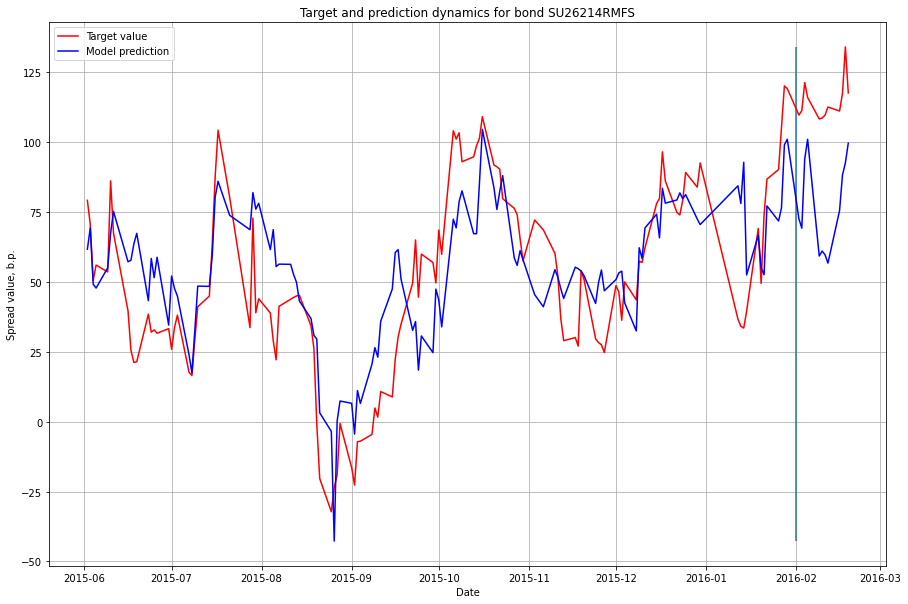

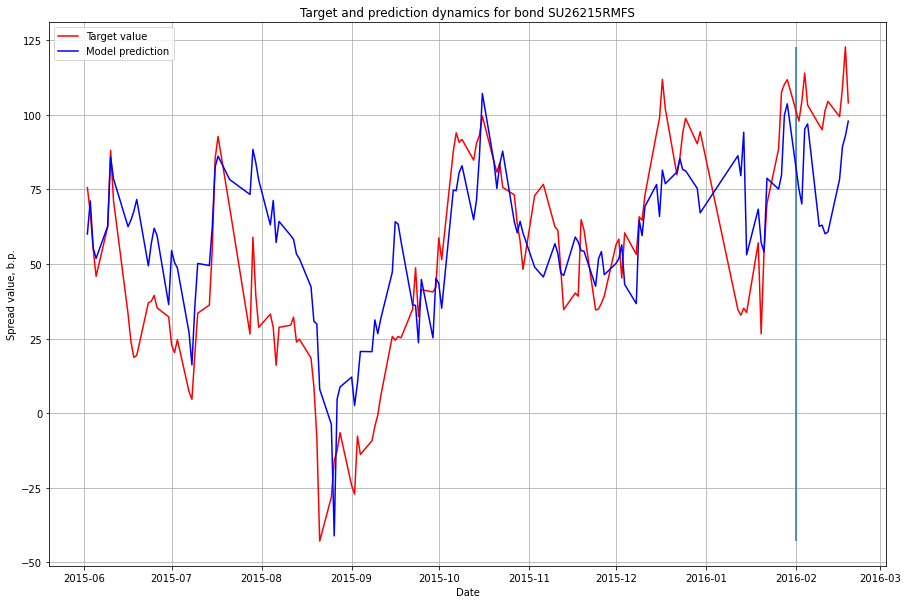

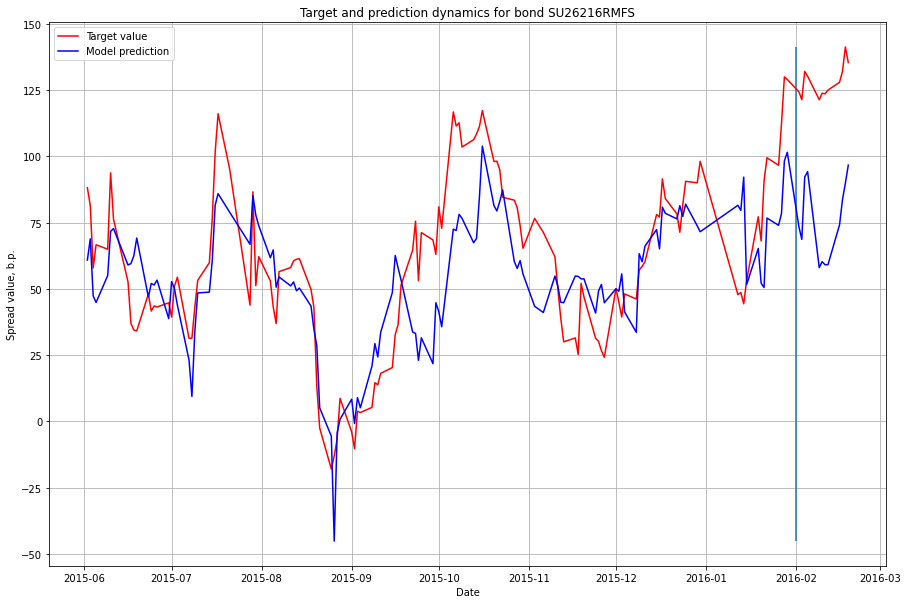

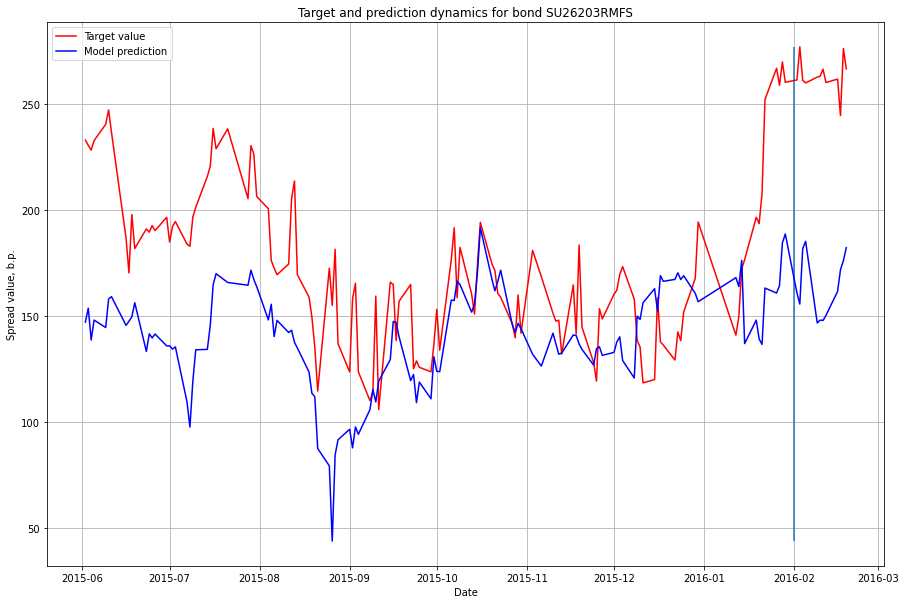

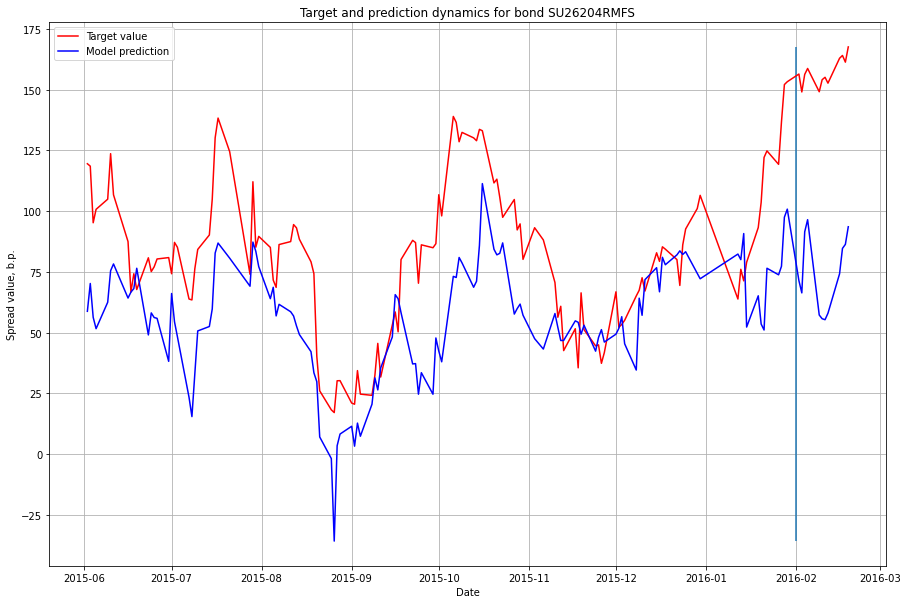

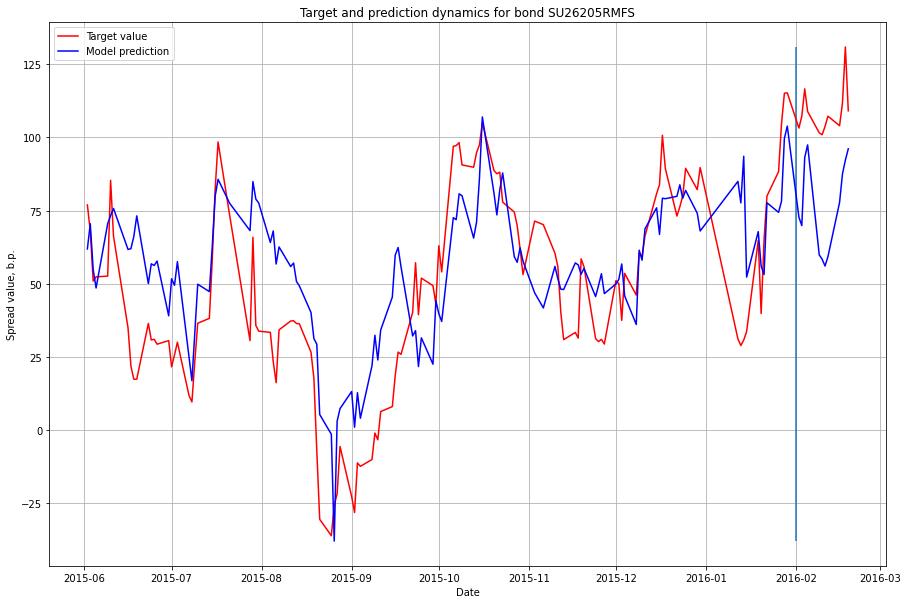

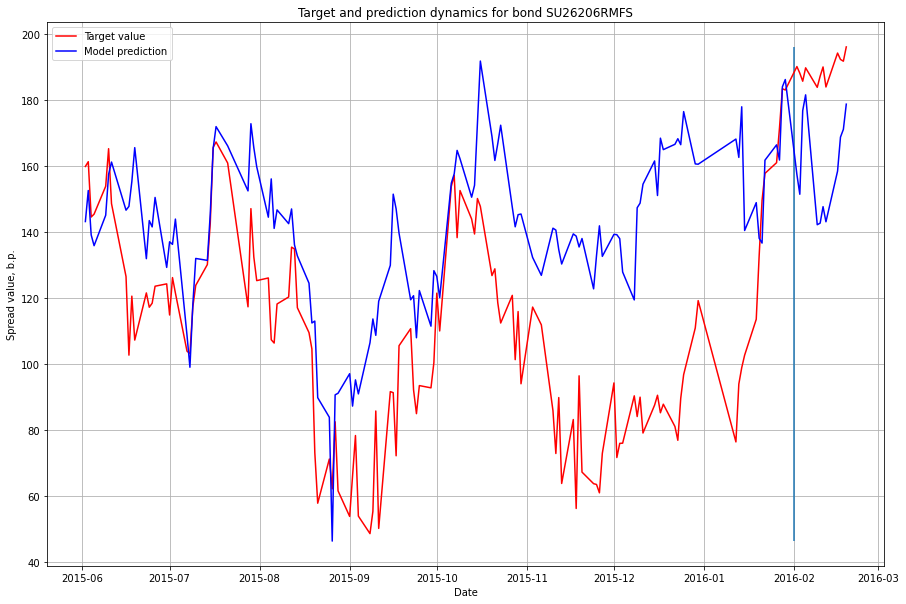

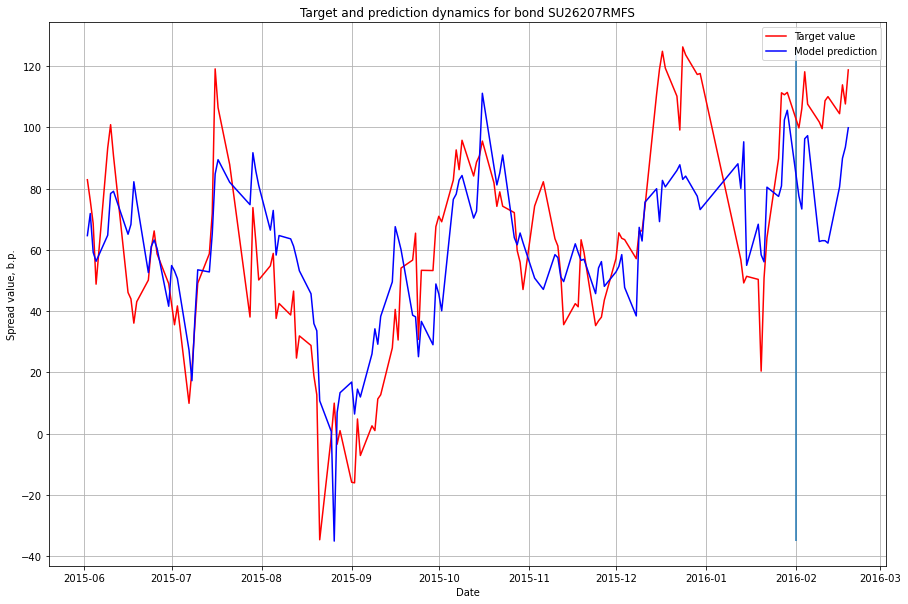

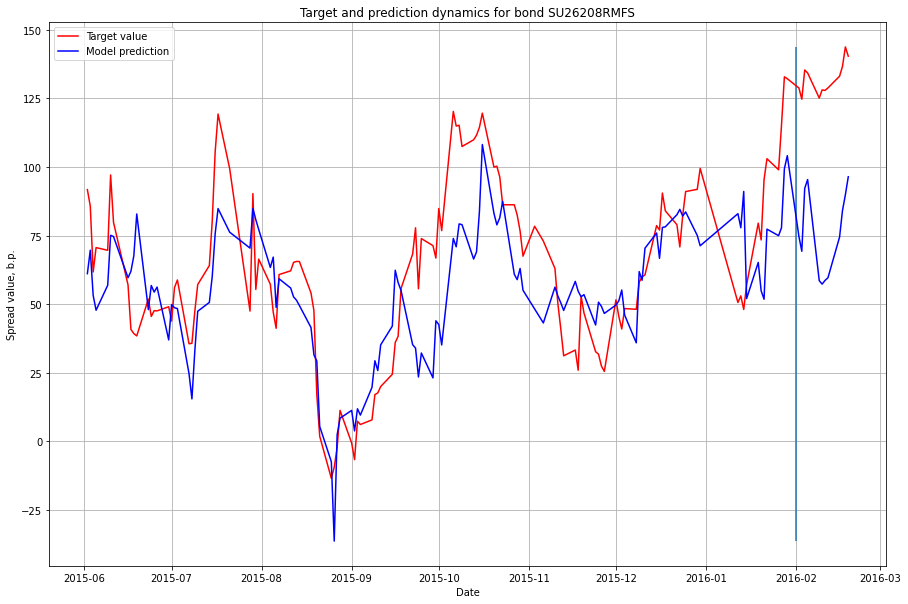

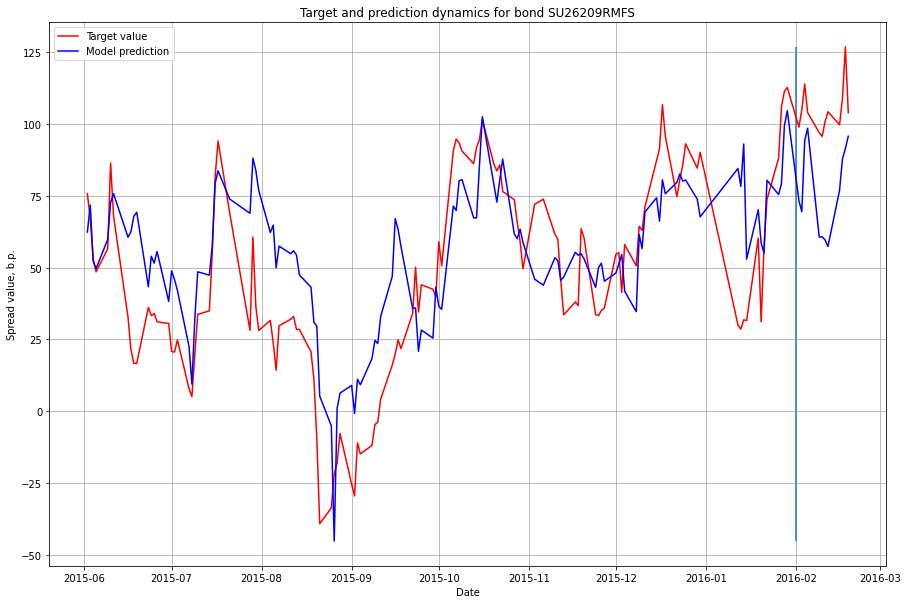

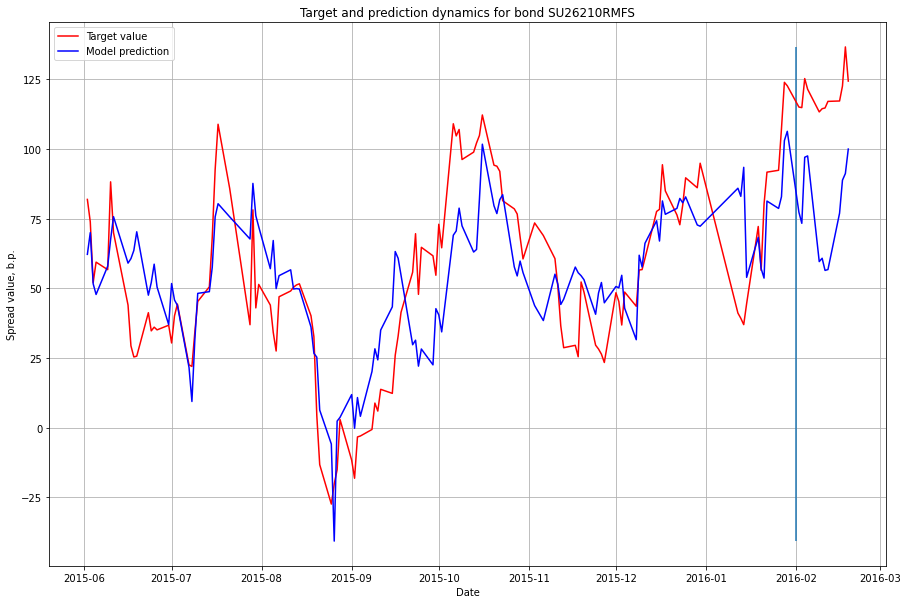

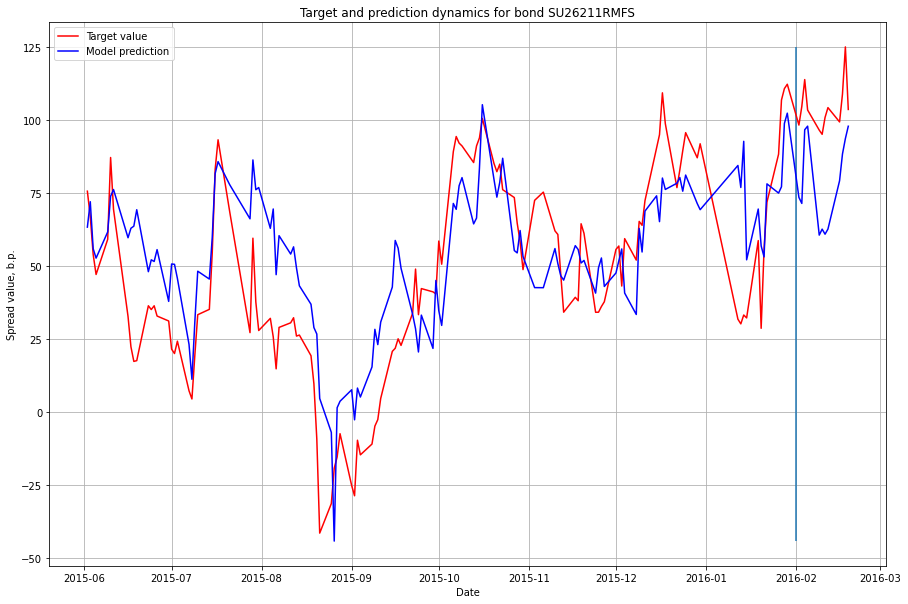

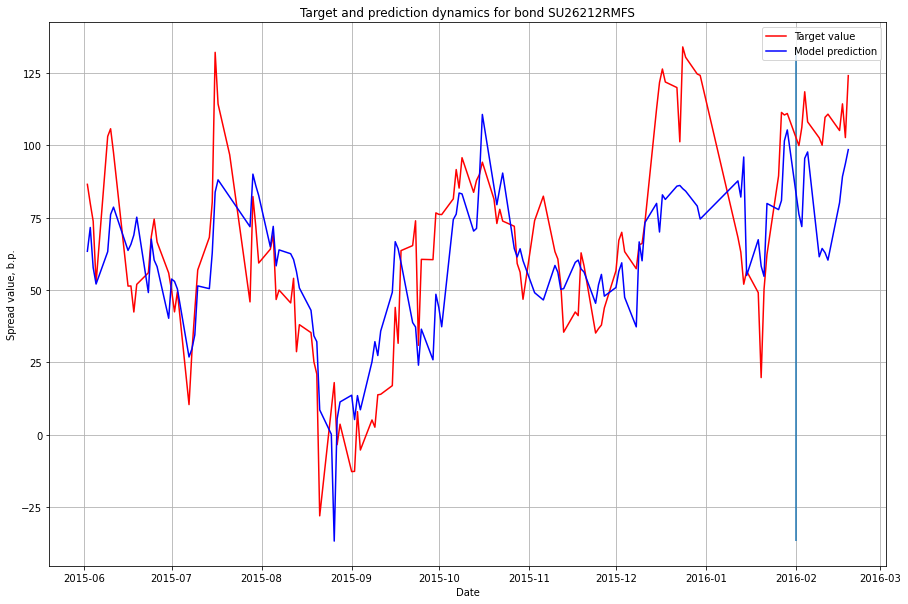

In [39]:
make_plots(train_data, test_data, 'graphs/FE_model', inverse_transfer)

### Pooled model

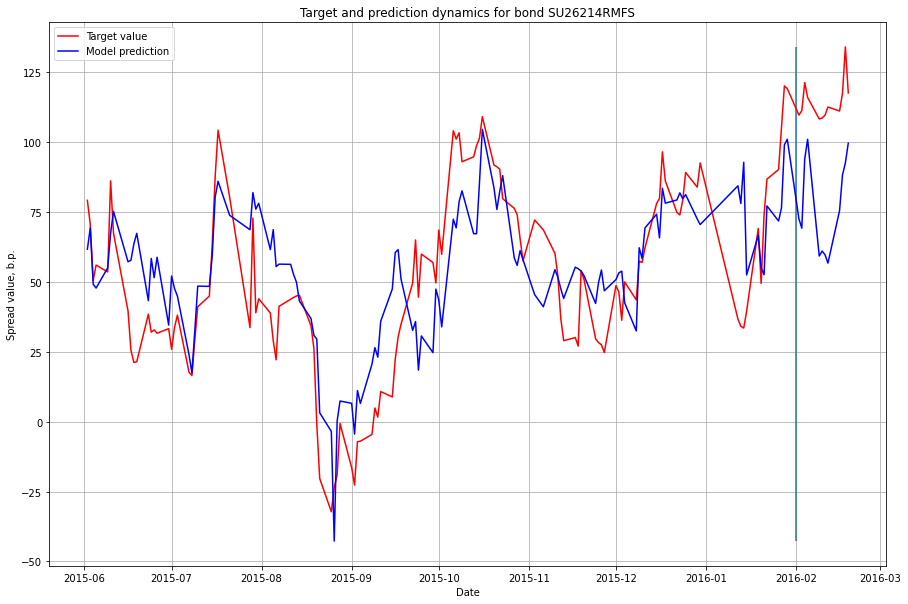

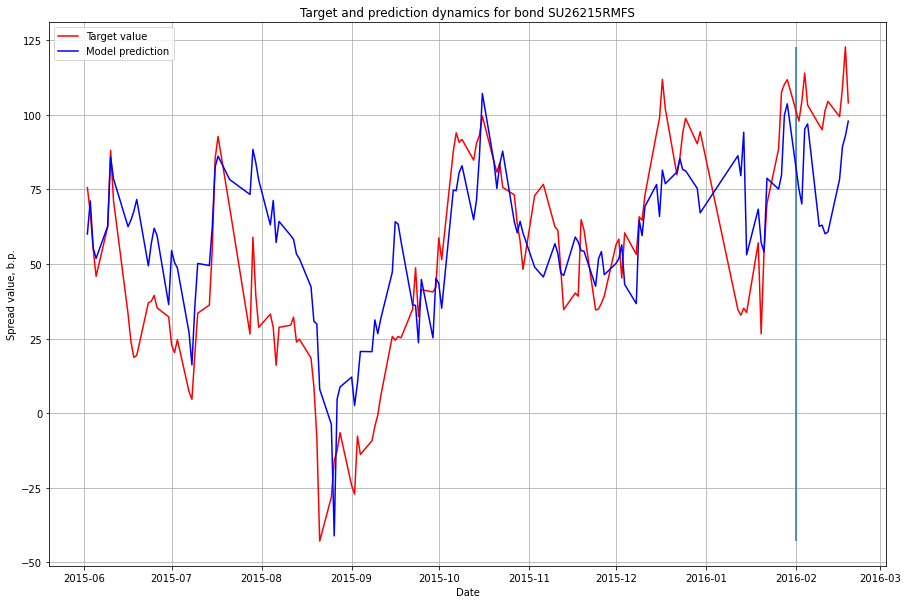

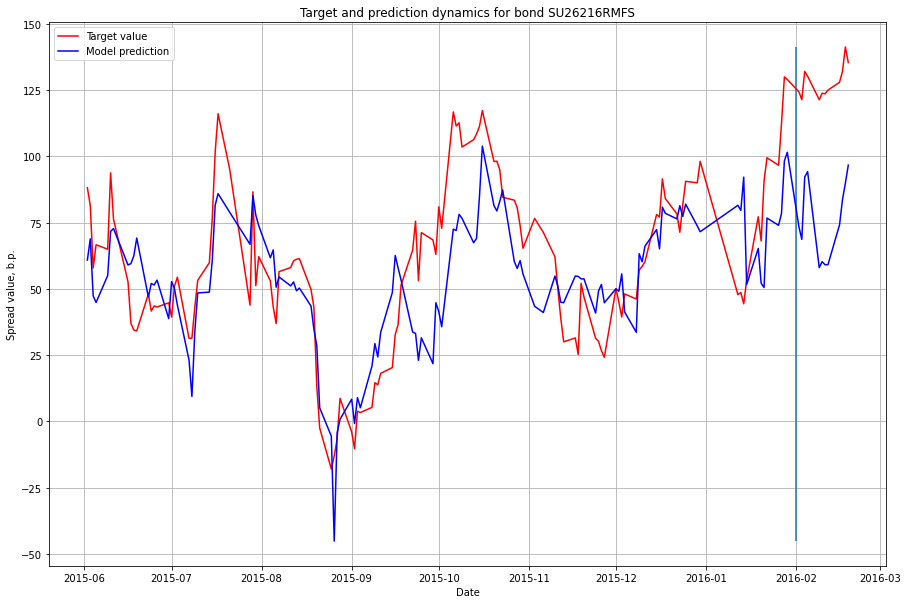

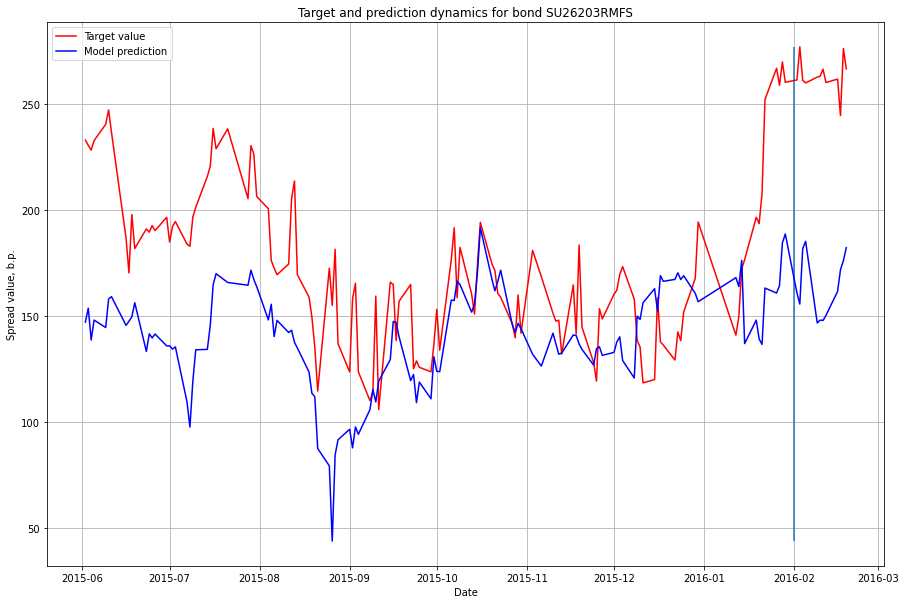

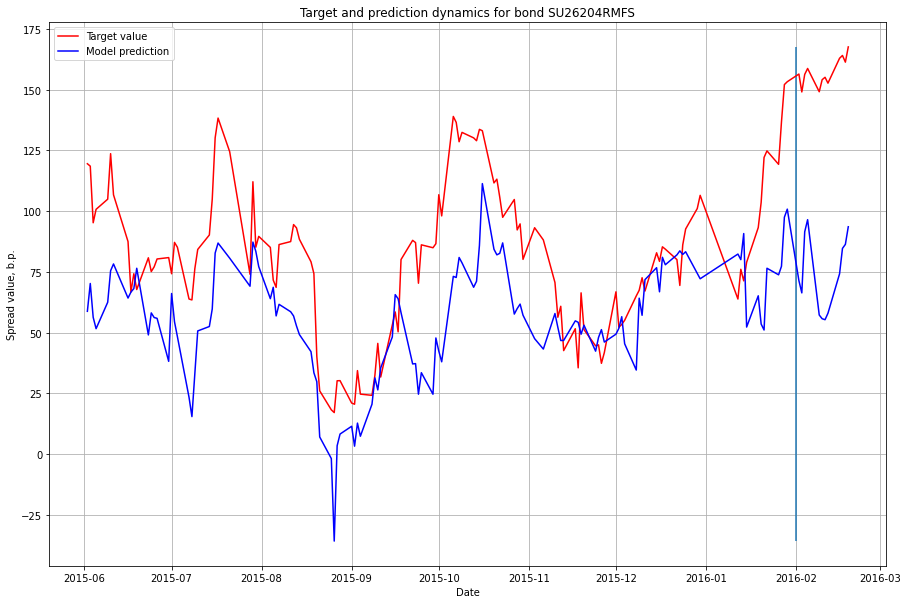

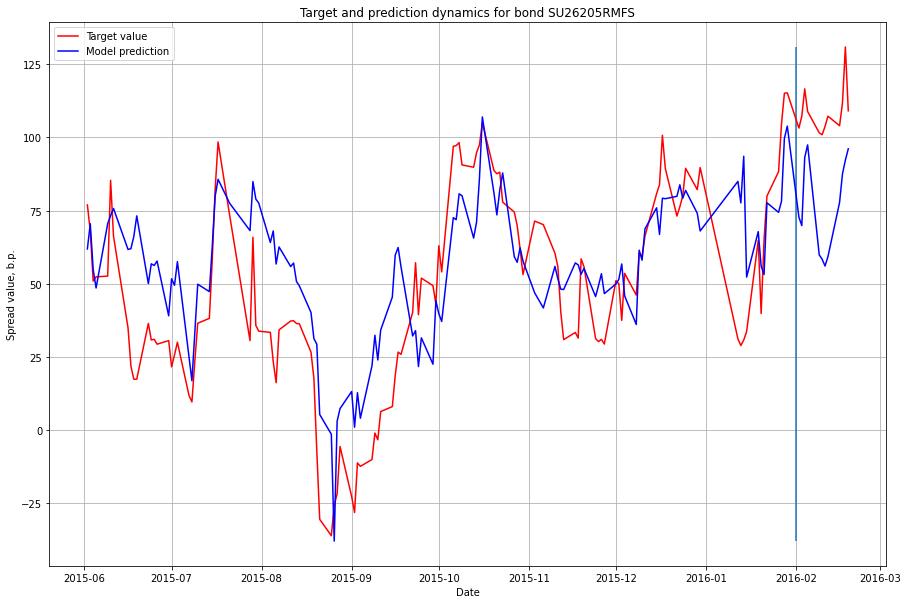

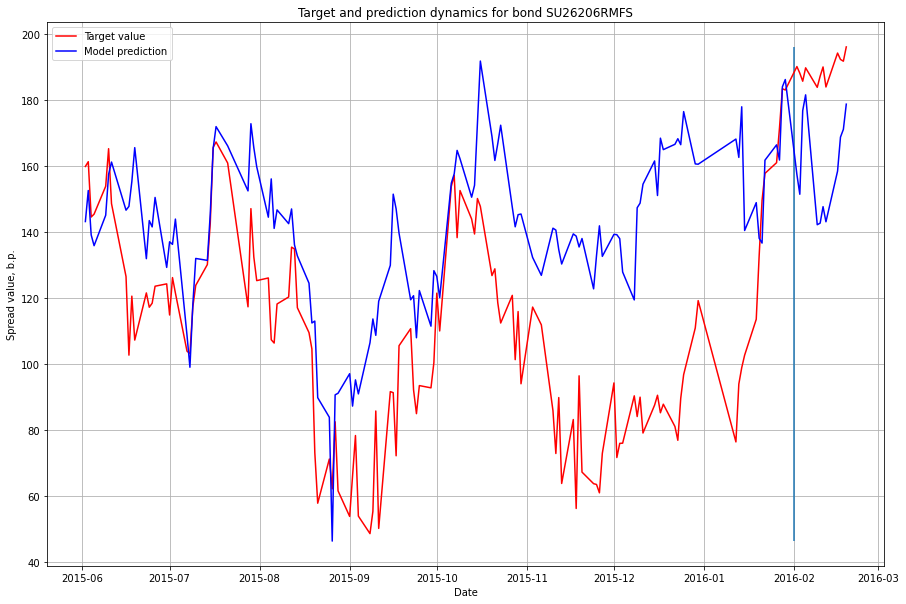

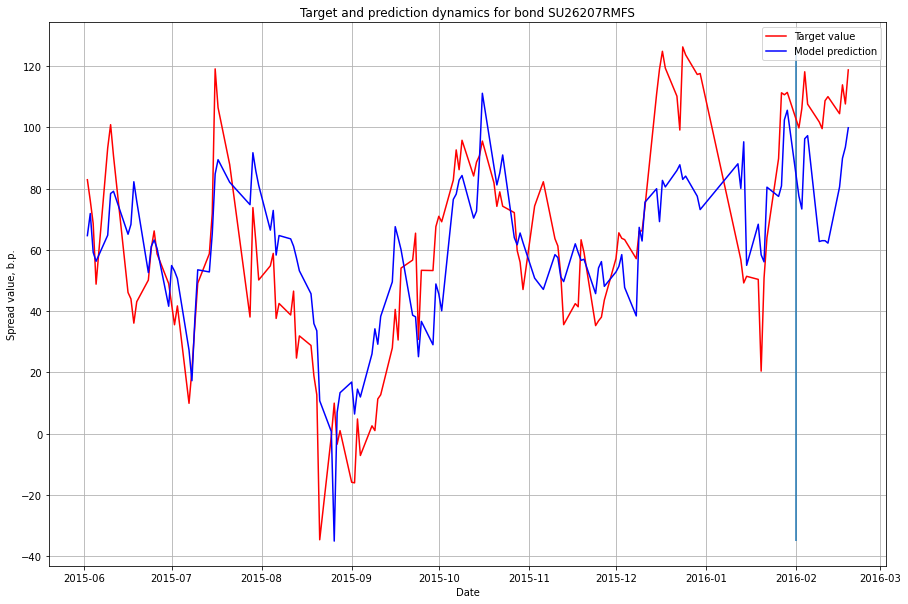

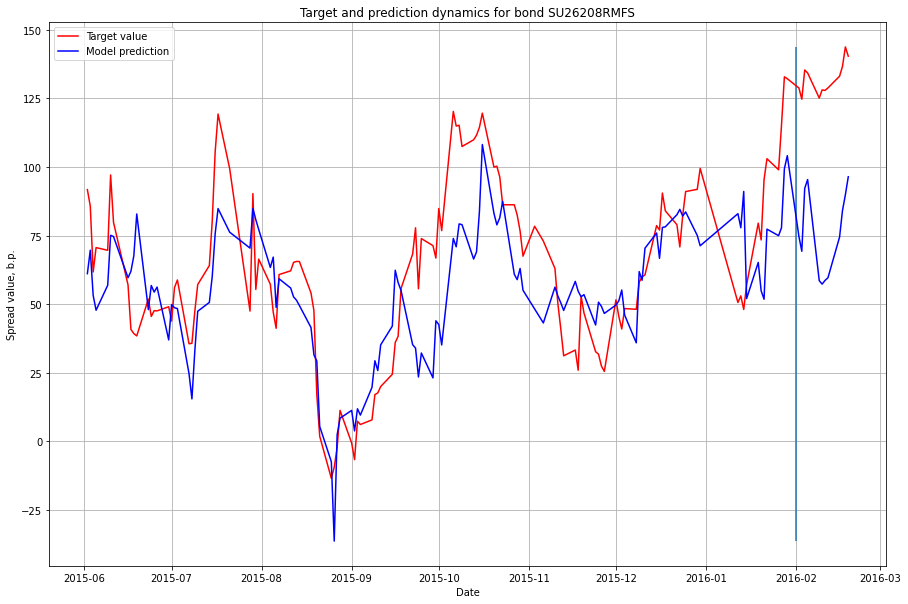

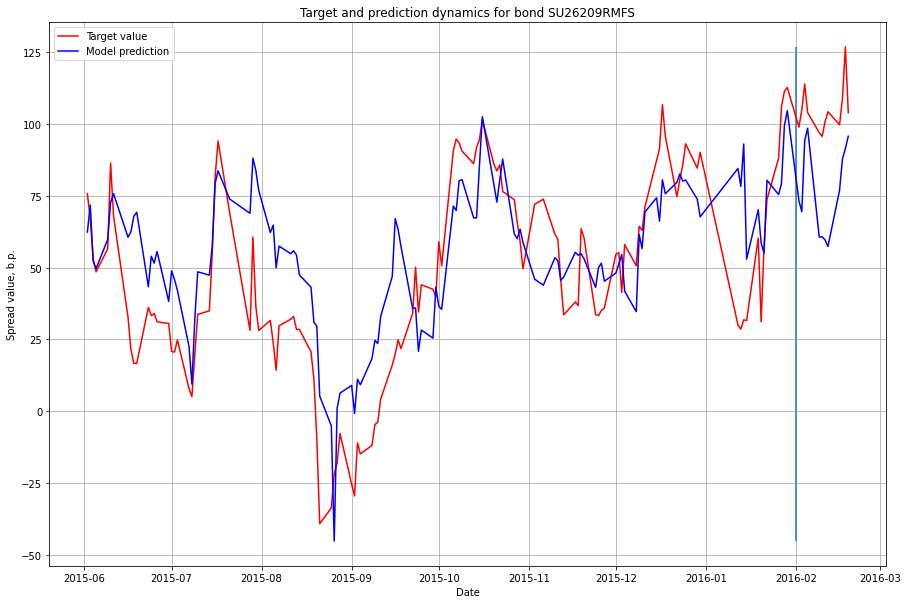

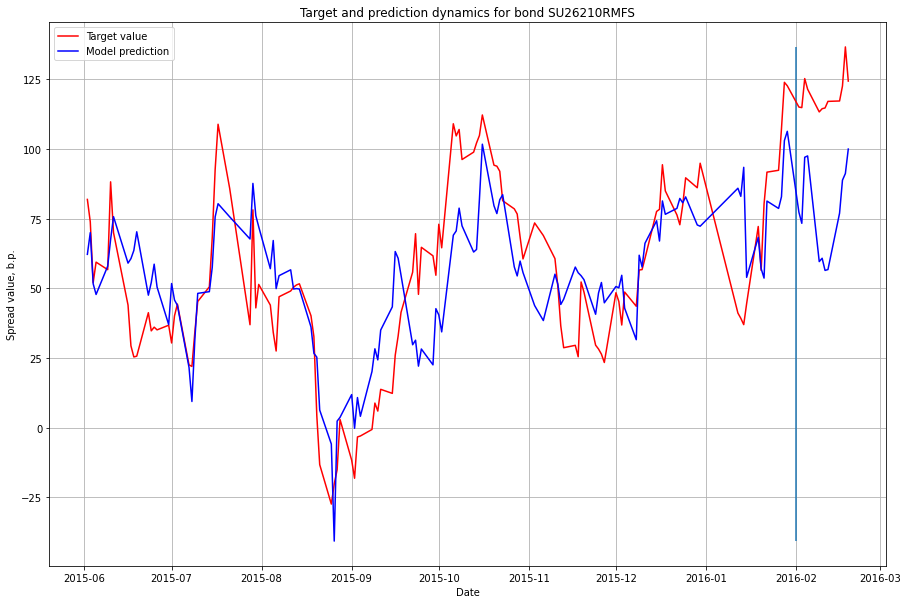

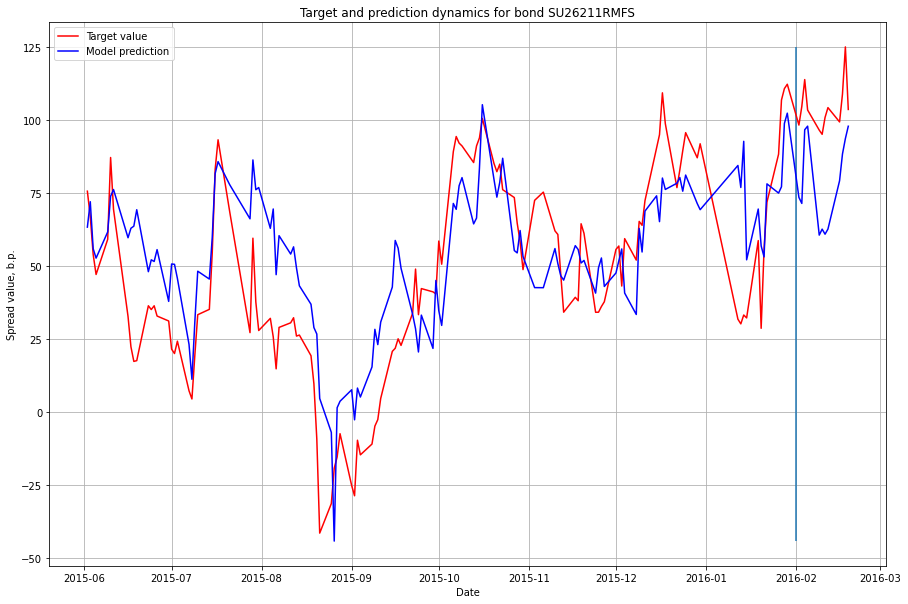

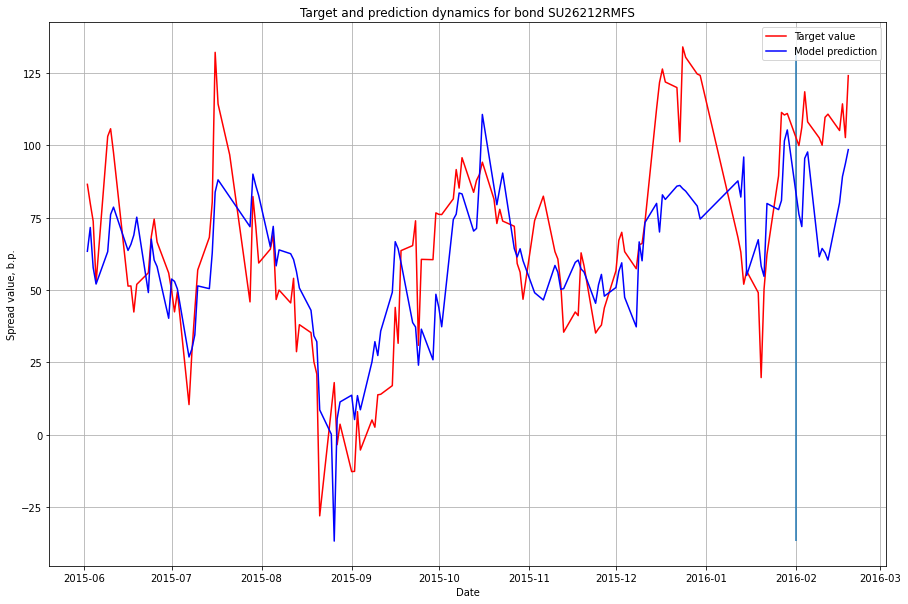

In [40]:
pooled_model, train_data, train_summary, \
test_data, test_summary = build_model(train_sample, test_sample, PooledOLS, exog_vars)
make_plots(train_data, test_data, 'graphs/pooled_model', inverse_transfer)

### Compare models

In [29]:
compare({"Between Estimator": be_model, 
               "Random Effects": re_model, 
               "Fixed Effects": fe_model,
               "Pooled": pooled_model})

Model Comparison                                 
==================================================================================
                      Between Estimator  Random Effects Fixed Effects       Pooled
----------------------------------------------------------------------------------
Dep. Variable                    target          target        target       target
Estimator                    BetweenOLS   RandomEffects      PanelOLS    PooledOLS
No. Observations                     13            1664          1664         1664
Cov. Est.                    Unadjusted      Unadjusted    Unadjusted   Unadjusted
R-squared                        0.8175          0.5170        0.6635       0.6635
R-Squared (Within)              -3.9384          0.5160        0.5153       0.5153
R-Squared (Between)              0.8175          0.7980        0.7999       0.7999
R-Squared (Overall)             -1.4615          0.6629        0.6635       0.6635
F-statistic                      0.8958          176.90        325.94       325.94
P-value (F-stat)                 0.6349          0.0000        0.0000       0.0000
=====================     ============= ===============  ============ ============
const                            0.0009          348.76        347.36       347.36
                            (1.253e-12)        (23.351)      (29.537)     (29.537)
CDS                              0.2004         -1.0115       -1.0104      -1.0104
                             (1.69e-07)       (-22.332)     (-18.535)    (-18.535)
CDS_new_slope                    0.0612          1.3535        1.3558       1.3558
                            (9.264e-09)        (22.020)      (18.325)     (18.325)
CDS_dummy                        0.0004         -304.13       -304.65      -304.65
                                              (-22.637)     (-18.839)    (-18.839)
RVI                              0.0348         -3.0446       -3.0372      -3.0372
                            (3.213e-09)       (-14.173)     (-11.748)    (-11.748)
RVI_struct_coef                  0.0040         -4.4490       -4.5290      -4.5290
                            (5.816e-11)       (-6.2645)     (-5.3043)    (-5.3043)
struct_change_Jan             8.736e-05          220.15        222.29       222.29
                                               (6.9995)      (5.8743)     (5.8743)
USDRUB                           0.0603          1.0370        1.0060       1.0060
                            (6.336e-09)        (6.5602)      (5.3183)     (5.3183)
short_term_bond                  79.643          84.269        83.536       83.536
                               (2.5330)        (2.9234)      (43.011)     (43.011)
log_TC                          -0.6138          1.5168        2.6373       2.6373
                              (-0.0306)        (1.9967)      (3.7645)     (3.7645)
LT_TC                            704.29          9.4848        15.482       15.482
                               (0.4401)        (1.4778)      (2.0378)     (2.0378)
----------------------------------------------------------------------------------

T-stats reported in parentheses
PanelModelComparison, id: 0x7ff6bb6e42e0

# Comparison of Liquidity metrics models (RE)

In [31]:
TC_vars = ['log_TC', 'LT_TC']
tc_model, _, train_tc, _, test_tc = build_model(train_sample, test_sample, RandomEffects, TC_vars)

PD_vars = ['log_PD', 'LT_PD']
pd_model, _, train_pd, _, test_pd = build_model(train_sample, test_sample, RandomEffects, PD_vars)

BA_vars = ['log_BA', 'LT_BA']
ba_model, _, train_ba, _, test_ba = build_model(train_sample, test_sample, RandomEffects, BA_vars)

tc_ba = ['log_TC', 'log_BA']
two_vars, _, train_2, _, test_2 = build_model(train_sample, test_sample, RandomEffects, tc_ba)

tc_ba_upd = ['log_TC', 'log_BA']
two_vars_upd, _, train_2_upd, _, test_2_upd = build_model(train_sample, test_sample, RandomEffects, tc_ba_upd)

all_lm_vars = ['log_TC', 'log_BA', 'log_PD']
three_vars, _, train_3, _, test_3 = build_model(train_sample, test_sample, RandomEffects, all_lm_vars)

all_lm_vars_upd = ['log_TC', 'log_BA', 'log_PD', 'LT_TC', 'LT_BA', 'LT_PD']
three_vars_upd, _, train_3_upd, _, test_3_upd = build_model(train_sample, test_sample, RandomEffects, 
                                                            all_lm_vars_upd)

compare({"Trading Count model": tc_model, 
               "Price Dispersion model": pd_model, 
               "Bid-Ask spread model": ba_model,
        "Trading count and Bid-ask spread": two_vars,
        "TC + BA with low-trading days indicators":two_vars_upd,
        "TC + BA + PD": three_vars,
        "TC + BA + PD with indicators": three_vars_upd})

Model Comparison                                                                                              
============================================================================================================================================================================================================
                      Trading Count model Price Dispersion model Bid-Ask spread model Trading count and Bid-ask spread TC + BA with low-trading days indicators    TC + BA + PD TC + BA + PD with indicators
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                      target                 target               target                           target                                   target          target                       target
Estimator                   RandomEffects          RandomEffects        RandomEffects                    RandomEffects                            RandomEffects   RandomEffects                RandomEffects
No. Observations                     1664                   1664                 1664                             1664                                     1664            1664                         1664
Cov. Est.                      Unadjusted             Unadjusted           Unadjusted                       Unadjusted                               Unadjusted      Unadjusted                   Unadjusted
R-squared                          0.0225                 0.0016               0.0211                           0.0335                                   0.0335          0.0334                       0.0353
R-Squared (Within)                 0.0222                 0.0015               0.0179                           0.0298                                   0.0298          0.0299                       0.0318
R-Squared (Between)                0.0666                 0.0089               0.1349                           0.1375                                   0.1375          0.1351                       0.1545
R-Squared (Overall)                0.0453                 0.0054               0.0788                           0.0859                                   0.0859          0.0847                       0.0957
F-statistic                        19.117                 1.3258               17.900                           28.770                                   28.770          19.132                       10.119
P-value (F-stat)                   0.0000                 0.2659               0.0000                           0.0000                                   0.0000          0.0000                       0.0000
=====================     ===============        ===============      ===============                  ===============                          =============== ===============              ===============
const                              53.719                 67.624               88.466                           69.669                                   69.669          70.028                       71.466
                                 (5.4410)               (10.174)             (14.468)                         (11.190)                                 (11.190)        (10.793)                     (9.9519)
log_TC                             5.2786                                                                       4.1911                                   4.1911          4.1850                       4.2003
                                 (6.1824)                                                                     (4.8273)                                 (4.8273)        (4.8191)                     (4.6813)
LT_TC                              12.654                                                                                                                                                             1

# Macro + Indices

In [41]:
RVI_vars = ['RVI', 'struct_change_Jan']
rvi_model, rvi_train_sample, train_rvi, rvi_test_sample, test_rvi = build_model(train_sample, test_sample, RandomEffects, RVI_vars)

CDS_vars = ['CDS', 'CDS_new_slope', 'CDS_dummy']
cds_model, _, train_cds, _, test_cds = build_model(train_sample, test_sample, RandomEffects, CDS_vars)

USDRUB_vars = ['USDRUB', 'struct_change_Jan', 'oil_shock_1st_USDRUB_dummy']
usdrub_model, _, train_usdrub, _, test_usdrub = build_model(train_sample, test_sample, RandomEffects, USDRUB_vars)

rvi_short_vars = RVI_vars + ['short_term_bond']
rvi_short_model, _, train_rvi_short, _, test_rvi_short = build_model(train_sample, 
                                                                     test_sample, RandomEffects, rvi_short_vars)

rvi_cds_vars = RVI_vars + CDS_vars
rvi_cds, _, train_rvi_cds, _, test_rvi_cds = build_model(train_sample, test_sample, RandomEffects, rvi_cds_vars)

macro_ind_vars = ['RVI', 'struct_change_Jan', 'CDS', 'CDS_new_slope', 'CDS_dummy', 'USDRUB']
macro_ind, _, train_3_macro, _, test_3_macro = build_model(train_sample, test_sample, RandomEffects, macro_ind_vars)

Mi_short = macro_ind_vars + ['short_term_bond']
short_upd, _, train_short_upd, _, test_short_upd = build_model(train_sample, test_sample, RandomEffects, Mi_short)

all_vars = Mi_short + TC_vars
all_model, _, train_all, _, test_all = build_model(train_sample, test_sample, RandomEffects, 
                                                            all_vars)

compare({"RVI index model": rvi_model, 
         "CDS 1Y model": cds_model, 
         "USDRUB model": usdrub_model,
         "RVI and CDS model": rvi_cds,
         "USDRUB, RVI and CDS model":macro_ind,
         "Indices + short-term bond adj.": short_upd,
         "RVI and short-term bond adj.":rvi_short_model,
         "Final model": all_model})

Model Comparison                                                                                          
====================================================================================================================================================================================================
                             RVI index model    CDS 1Y model    USDRUB model RVI and CDS model USDRUB, RVI and CDS model Indices + short-term bond adj. RVI and short-term bond adj.     Final model
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                         target          target          target            target                    target                         target                       target          target
Estimator                      RandomEffects   RandomEffects   RandomEffects     RandomEffects             RandomEffects                  RandomEffects                RandomEffects   RandomEffects
No. Observations                        1664            1664            1664              1664                      1664                           1664                         1664            1664
Cov. Est.                         Unadjusted      Unadjusted      Unadjusted        Unadjusted                Unadjusted                     Unadjusted                   Unadjusted      Unadjusted
R-squared                             0.3461          0.4089          0.0628            0.4878                    0.5026                         0.5056                       0.3550          0.5060
R-Squared (Within)                    0.3474          0.4102          0.0632            0.4889                    0.5035                         0.5035                       0.3474          0.5045
R-Squared (Between)                 2.22e-16          0.0000        1.11e-16            0.0000                  1.11e-16                         0.7941                       0.7941          0.7973
R-Squared (Overall)                   0.1665          0.1966          0.0303            0.2343                    0.2413                         0.6548                       0.5800          0.6570
F-statistic                           439.48          382.74          37.098            315.84                    279.06                         241.96                       304.57          188.23
P-value (F-stat)                      0.0000          0.0000          0.0000            0.0000                    0.0000                         0.0000                       0.0000          0.0000
============================ =============== =============== ===============   ===============           ===============                ===============              =============== ===============
const                                 265.44          351.67          139.01            391.84                    368.93                         355.81                       252.33          354.20
                                    (20.340)        (23.376)        (5.7630)          (24.409)                  (21.511)                       (28.675)                     (27.625)        (26.252)
RVI                                  -5.4509                                           -3.2627                   -3.4980                        -3.4980                      -5.4509         -3.5006
                                   (-27.791)                                         (-15.932)                 (-17.093)                      (-17.093)                    (-27.791)       (-17.118)
struct_change_Jan                     74.450                          39.863            37.164                    26.111                         26.111                       74.450          24.637
                                    (25.556)                        (8.2640)          (10.433)                  (6.7785)                       (6.7785

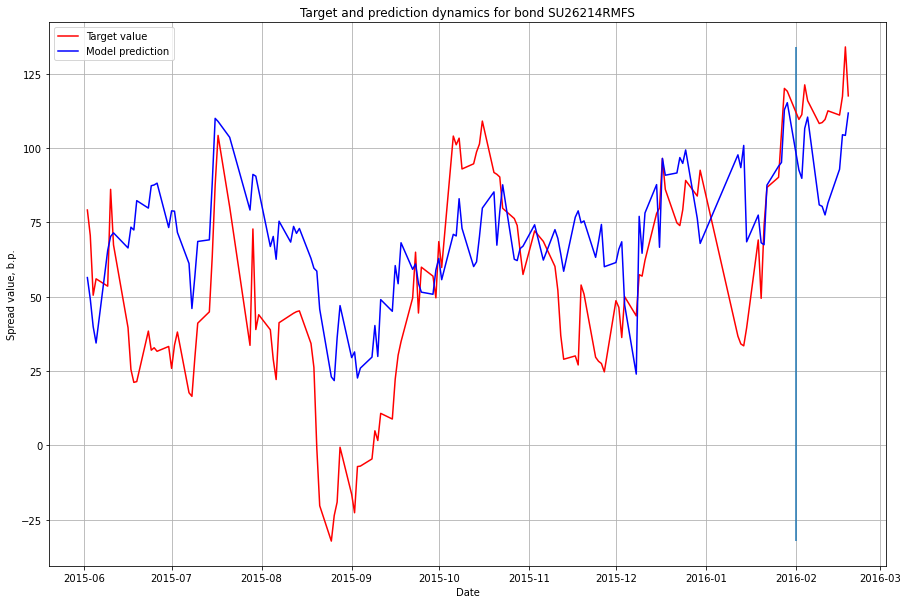

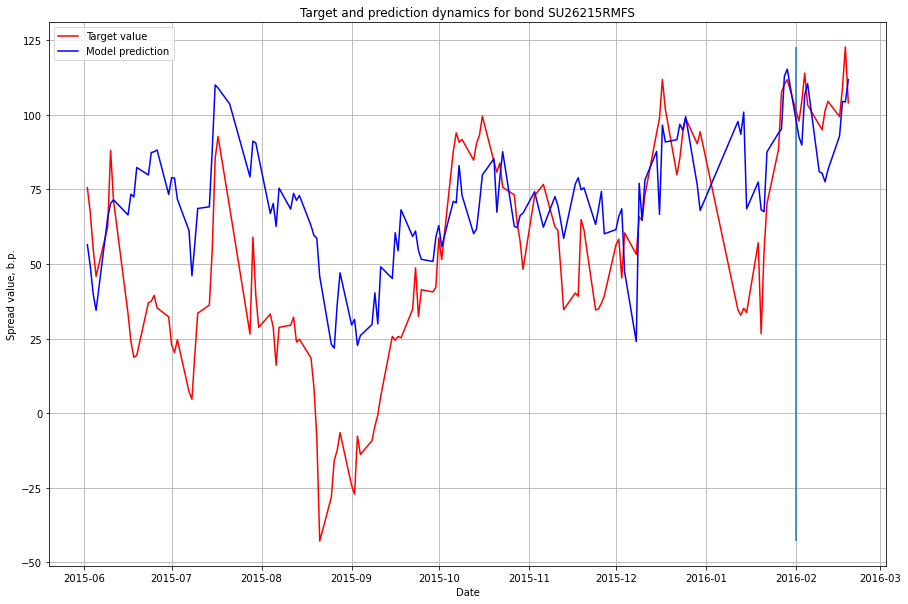

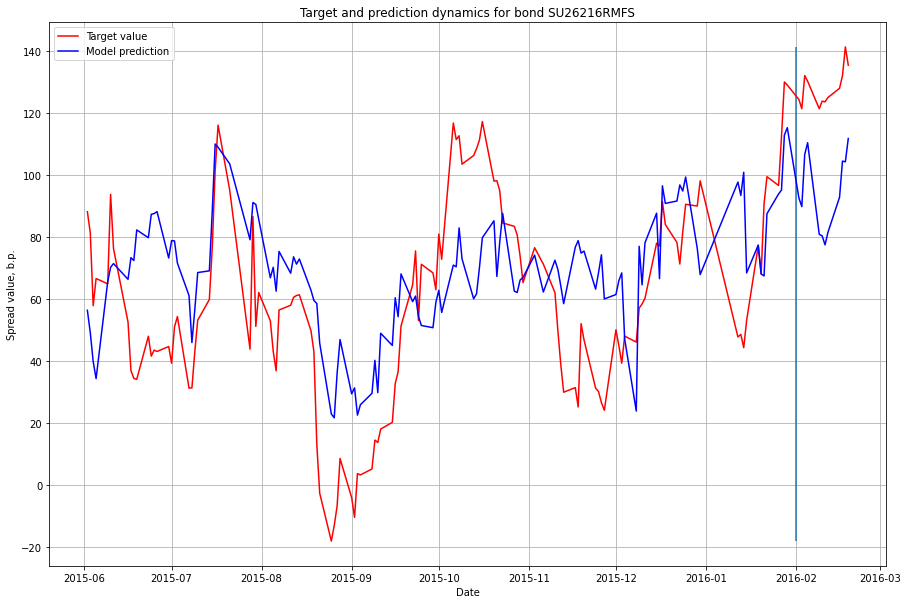

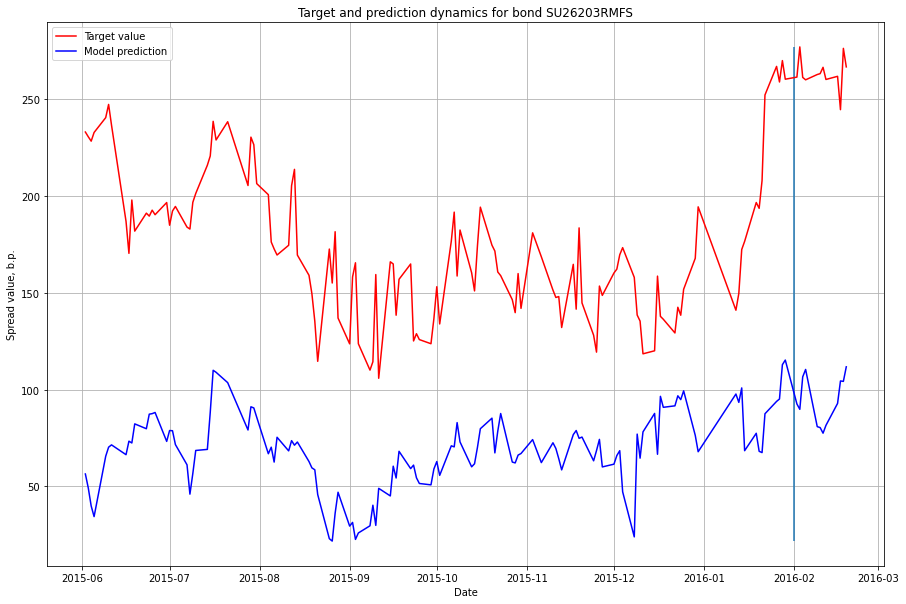

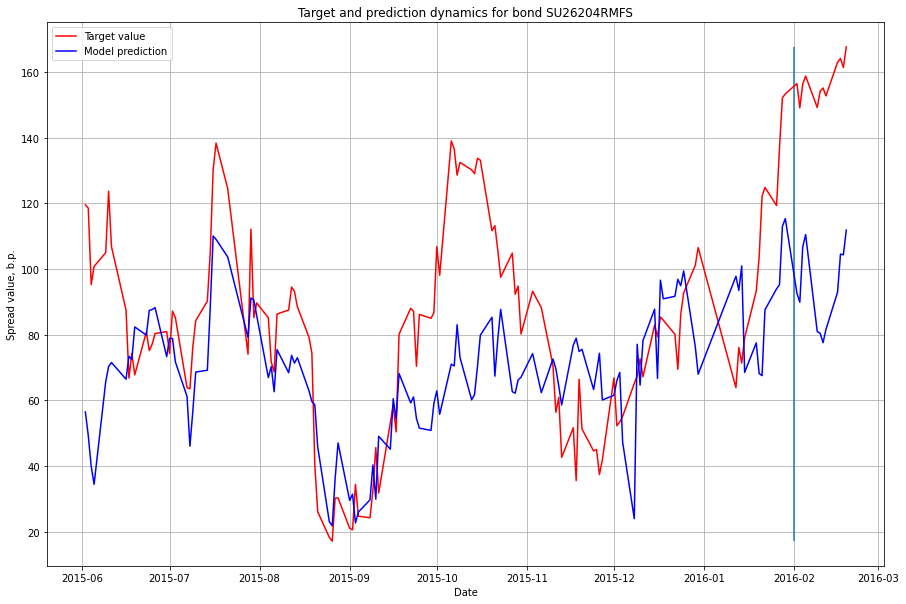

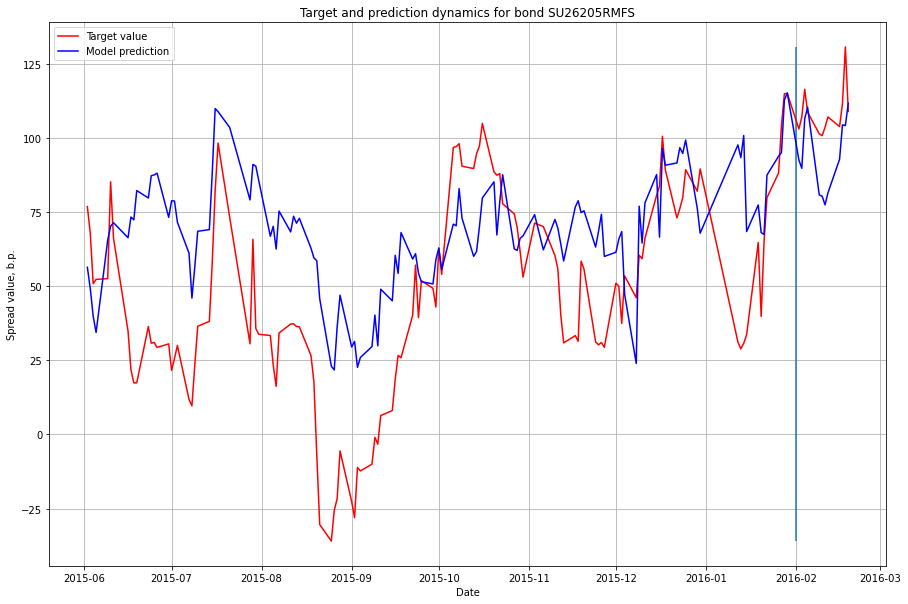

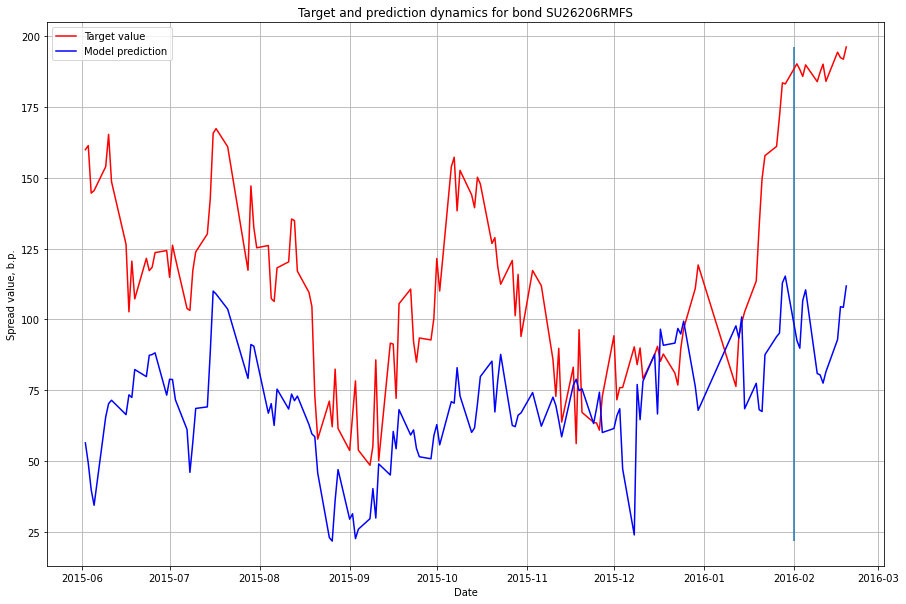

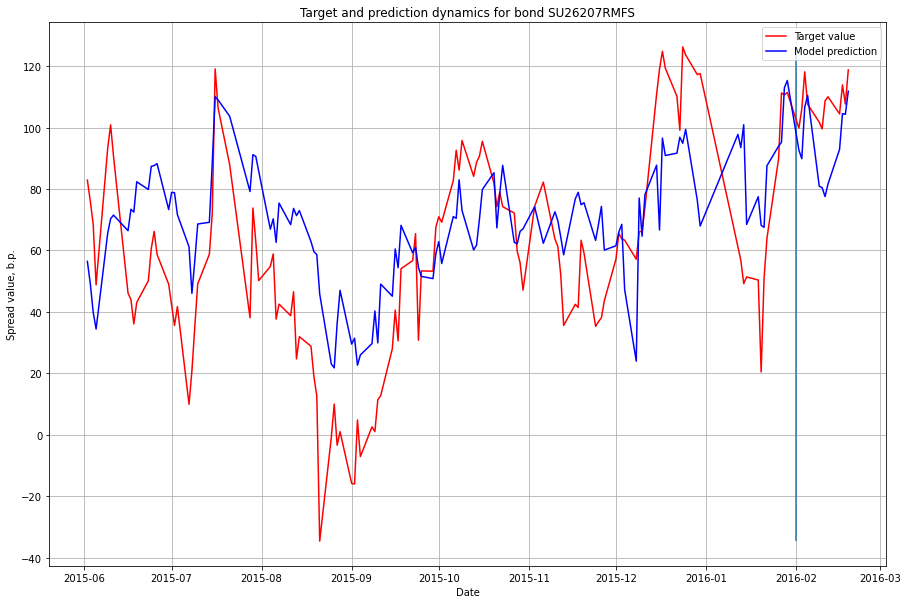

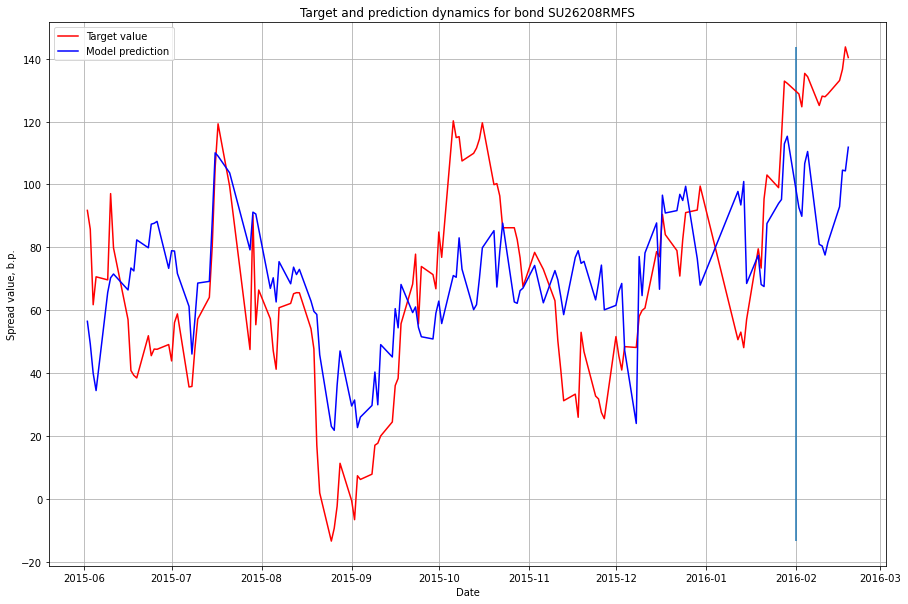

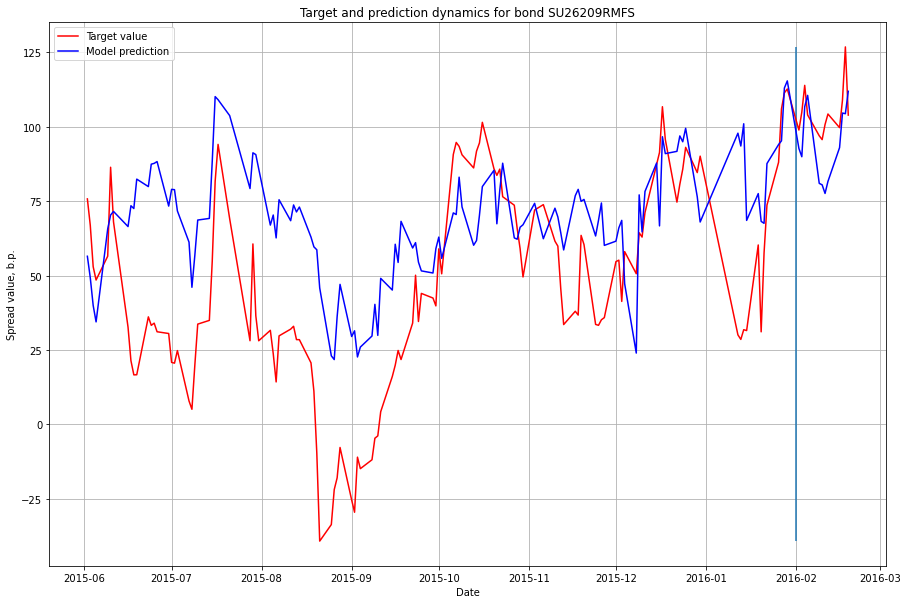

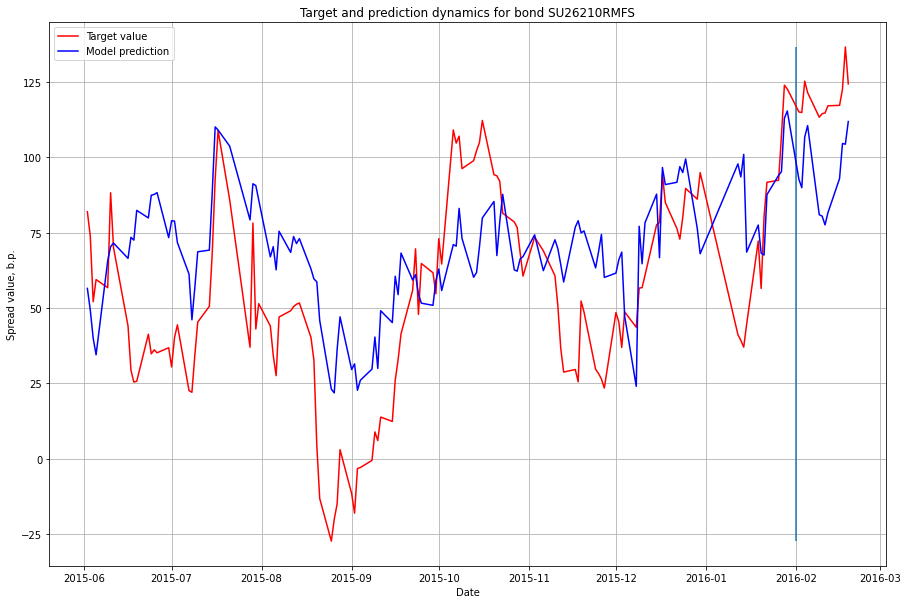

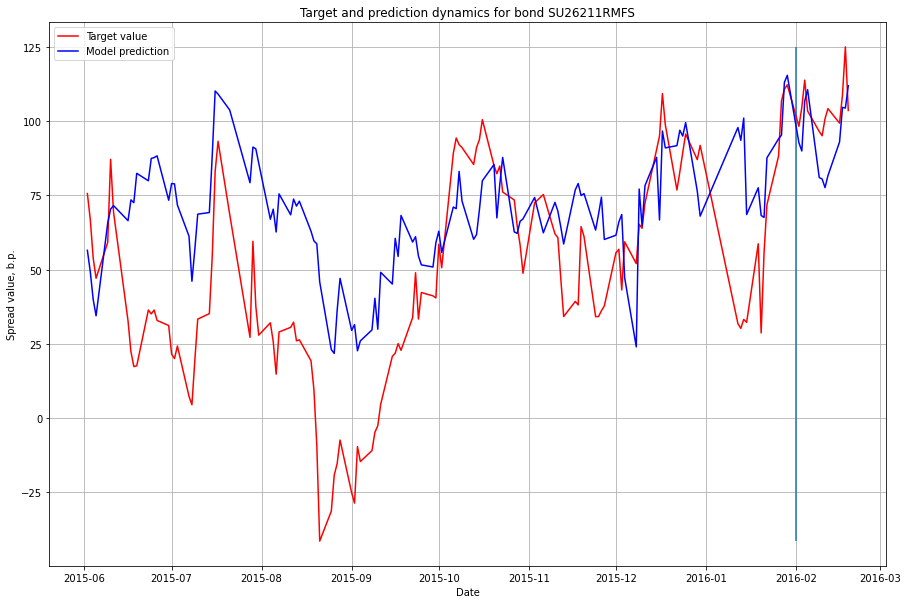

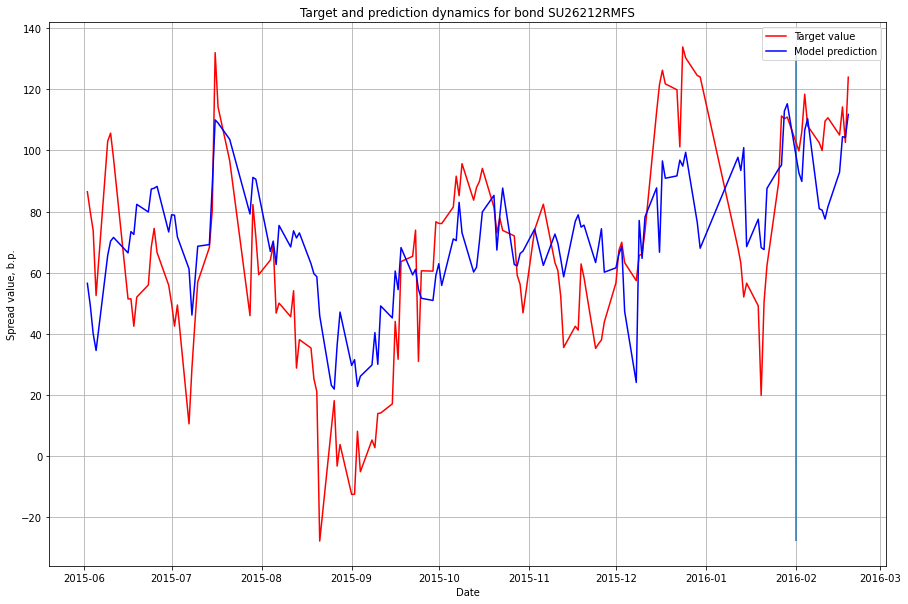

In [42]:
make_plots(rvi_train_sample, rvi_test_sample, 'graphs/RVI_model', inverse_transfer)

In [45]:
def make_statistics_summary(dict_data):
    info_df_mae = pd.DataFrame(index = ['train sample', 'test sample'], columns = list(dict_data.keys()))
    info_df_rmse = pd.DataFrame(index = ['train sample', 'test sample'], columns = list(dict_data.keys()))
    for key in dict_data.keys():
        info_df_mae.loc['train sample', key] = dict_data[key][0].mean()['MAE']
        info_df_mae.loc['test sample', key] = dict_data[key][1].mean()['MAE']
        
        info_df_rmse.loc['train sample', key] = dict_data[key][0].mean()['RMSE']
        info_df_rmse.loc['test sample', key] = dict_data[key][1].mean()['RMSE']
    return info_df_mae, info_df_rmse

In [46]:
mae_mi, rmse_mi = make_statistics_summary({  "RVI index model": [train_rvi, test_rvi], 
                                             "CDS 1Y model": [train_cds, test_cds], 
                                             "USDRUB model": [train_usdrub, test_usdrub],
                                             "RVI and CDS model": [train_rvi_cds, test_rvi_cds],
                                             "USDRUB, RVI and CDS model":[train_3_macro, test_3_macro],
                                             "Indices + short-term bond adj.": [train_short_upd, test_short_upd],
                                             "RVI and short-term bond adj.":[train_rvi_short, test_rvi_short],
                                             "Final model": [train_all, test_all]})

### MAE statistics for all defined models

In [47]:
mae_mi

RVI index model CDS 1Y model USDRUB model RVI and CDS model  \
train sample       32.764222    31.784071    36.326125         30.403499   
test sample        40.415647    48.593552    43.256659         44.564752   

             USDRUB, RVI and CDS model Indices + short-term bond adj.  \
train sample                 29.917509                       21.88615   
test sample                  45.493941                      45.493941   

             RVI and short-term bond adj. Final model  
train sample                    24.856155   21.808092  
test sample                     39.691598   45.812268

### RMSE statistics for all defined models

In [48]:
rmse_mi

RVI index model CDS 1Y model USDRUB model RVI and CDS model  \
train sample       37.927047    36.884028     42.74038         35.375448   
test sample        41.929033    49.645517    44.338055         45.288098   

             USDRUB, RVI and CDS model Indices + short-term bond adj.  \
train sample                 34.947439                      26.780816   
test sample                  46.083212                      45.902503   

             RVI and short-term bond adj. Final model  
train sample                    30.172152   26.681622  
test sample                     41.160338   46.224494